In [1]:
#automatically reload stuff
%reload_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
from Constants import Const
import json
import Utils
import re
from sklearn.ensemble import AdaBoostClassifier, AdaBoostRegressor, RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.svm import SVC, SVR
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor

from sklearn.mixture import GaussianMixture, BayesianGaussianMixture
from sklearn.cluster import SpectralClustering, KMeans, AgglomerativeClustering
from sklearn.decomposition import PCA
from scipy.stats import chi2
from sklearn.feature_selection import mutual_info_regression, mutual_info_classif

from ast import literal_eval
import statsmodels.api as sm
import Metrics
import simplejson

from sklearn.metrics import roc_auc_score, f1_score, recall_score, precision_score,precision_recall_fscore_support, matthews_corrcoef

import joblib 
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning, HessianInversionWarning
warnings.simplefilter('ignore', ConvergenceWarning)
warnings.simplefilter('ignore', HessianInversionWarning)

In [113]:
def nested_responsify(dictionary):
    if isinstance(dictionary,list) or isinstance(dictionary,set):
        vals = [nested_responsify(x) for i,x in enumerate(dictionary)]
        return vals
    new_dict= {}
    for k,v in dictionary.items():
        if isinstance(v,dict):

            new_dict[k] = nested_responsify(v)
        else:
            new_dict[k] = v
    djson = simplejson.dumps(new_dict,default=np_converter,ignore_nan=True)
    return djson.replace('\\"','\"')

In [65]:
def add_sd_dose_clusters(sddf, 
                         clusterer = None,
                         features=None,
                         reducer=None,
                         organ_subset=None,
                         normalize = True,
                         prefix='',
                         n_clusters = 4,
                        ):
    if clusterer is None:
        clusterer = BayesianGaussianMixture(n_init=5,
                                            n_components=n_clusters, 
                                            covariance_type="full",
                                            random_state=100)
    if features is None:
        features=['V35','V40','V45','V50','V55','V60','V65']
    if reducer is None:
        reducer= None#PCA(len(organ_list),whiten=True)
    if organ_subset is None:
        organ_subset = Const.organ_list[:]
    organ_positions = [Const.organ_list.index(o) for o in organ_subset]
    vals = np.stack(sddf[features].apply(lambda x: np.stack([np.array([ii[i] for i in organ_positions]).astype(float) for ii in x]).ravel(),axis=1).values)
    if normalize:
        vals = (vals - vals.mean(axis=0))/(vals.std(axis=0) + .01)
    if reducer is not None:
        vals = reducer.fit_transform(vals)
    df = pd.DataFrame(vals,index = sddf.index)
    clusters = clusterer.fit_predict(vals)
    new_df = sddf.copy()
    cname= prefix+'dose_clusters'
    new_df[cname] = clusters
    new_df = reorder_clusters(new_df,
                              cname,
                              by='mean_dose',
                              organ_list=organ_subset#order by mean dose to clustered organs
                             )
    return new_df

def reorder_clusters(df,cname,by='moderate_6wk_symptoms',organ_list=None):
    df = df.copy()
    df2 = df.copy()
    severities = {}
    clusts = sorted(df[cname].unique())
    getmean = lambda d: d[by].astype(float).mean()
    if organ_list is not None and Utils.iterable(df[by].iloc[0]):
        keep_idx = [Const.organ_list.index(o) for o in organ_list]
        df[by] = df[by].apply(lambda x: [x[i] for i in keep_idx])
    if Utils.iterable(df[by].iloc[0]):
        getmean = lambda d: np.stack(d[by].apply(lambda x: np.array(x).sum()).values).mean()
    for c in clusts:
        subset = df[df[cname] == c]
        avg_severity = getmean(subset)
        severities[c] = avg_severity
    clust_order = np.argsort(sorted(severities.keys(), key = lambda x: severities[x]))
    clust_map = {c: clust_order[i] for i,c in enumerate(clusts)}
    df2[cname] = df[cname].apply(lambda x: clust_map.get(x))
    return df2

def get_df_dose_cols(df,key='DV'):
    return [c for c in df.columns if re.match('[' + key + ']\d+',c) is not None]

def get_df_symptom_cols(df):
    return [c for c in df.columns if 'symptoms_' in c if 'original' not in c]
    
def add_symptom_groups(df):
    smap = {
        'salivary': ['drymouth','taste'],
        'throat':['swallow','choke','teeth','sob','mucositis'],
        'mouth':['drymouth','teeth','swallow'],
        'core': ['pain','fatigue','nausea','sleep',
                 "distress", "sob", "memory", "appetite", 
                "drowsy", "drymouth", "sad", "vomit", "numb"],
        'interference': ["activity", "mood", "work", 
                "relations", "walking","enjoy"],
        'hnc': ["mucus", "swallow", "choke", "voice", "skin", 
                "constipation", "taste", "mucositis", "teeth"],
    }
    df = df.copy()
    for name, symptoms in smap.items():
        array = []
        for s in symptoms:
            svals = np.stack(df['symptoms_'+s].apply(lambda x: np.array(x)).values)
            array.append(svals)
        array = np.stack(array,axis=-1)
        #rounding in the same weird way you do in microprocessor code
        smean = (100*array.mean(axis=-1)).astype('int')/100.0
        smax = array.max(axis=-1)
        df['symptoms_'+name+'_max'] = smax.tolist()
        df['symptoms_'+name+'_mean'] = smean.tolist()
    return df

#overly complicated code to get various p-values using likelihood ratio test
#good for just correlations vs symptoms
def add_confounder_dose_limits(df,organ_list=None):
    #dose limits as binary values from https://applications.emro.who.int/imemrf/Rep_Radiother_Oncol/Rep_Radiother_Oncol_2013_1_1_35_48.pdf
    #not inlcudeing other stuff like eyes at this time
    #also, my max dose is weird so I'm using V10 for that because I feel like that makes sense
    #using the 
    if organ_list is None:
        organ_list = Const.organ_list[:]
    df = df.copy()
    original_cols = set(df.columns)
    getval = lambda organ,param: df[param].apply(lambda x: x[organ_list.index(organ)])
    get_lr_val = lambda organ,param: np.maximum(getval('Lt_'+organ,param),getval('Rt_'+organ,param))
    
    maxdose_var = 'max_dose'
   
    #xerostomia. >25 for 1 or >20 for both
    df['Parotid_Gland_limit'] = (get_lr_val('Parotid_Gland','mean_dose') > 20) | (getval('Lt_Parotid_Gland','mean_dose') > 25) | (getval('Rt_Parotid_Gland','mean_dose') > 25)
    
    #there is 50 for PEG tube and 60 for aspiration so i'll do 50
    for o in ['IPC','MPC',"SPC"]:
        df[o+"_limit"] = getval(o,'mean_dose') > 50
        df[o+"_limit2"] = getval(o,'mean_dose') > 60
    
    #edema
    df['Larynx_limit'] = getval('Larynx','V50') > 27
    
    #Esophagitus
    elimits = [('V35',50),('V50',40),('V70',20),('V60',30)]
    df['Esophagus_limit'] = np.stack([(getval('Esophagus',v) > lim) for v,lim in elimits]).sum(axis=0) > 0
    return df

def add_total_doses(df,cols):
    df = df.copy()
    for col in cols:
        if col in df.columns:
            df['total_'+col] = df[col].apply(np.sum)
    return df
    
def load_dose_symptom_data(use_lstm=False,file= None):
    if file is not None:
        data = pd.read_csv(Const.data_dir + file)
    else:
        if use_lstm:
            data = pd.read_csv(Const.data_dir + 'lstm_dose_symptoms_merged.csv')
        else:
            data = pd.read_csv(Const.data_dir + 'dose_symptoms_merged.csv')
    to_drop = [c for c in data.columns if 'symptom' in c and ('symptoms_' not in c or 'original' in c)]
    data = data.drop(to_drop,axis=1)
    dose_cols = get_df_dose_cols(data)
    s_cols = get_df_symptom_cols(data) 
    for c in dose_cols + s_cols + ['max_dose','mean_dose','volume','dates']:
        try:
            data[c] = data[c].apply(literal_eval)
        except Exception as e:
            print(c,e)
    data = add_symptom_groups(data)
    data = add_total_doses(data,['mean_dose'])
    data = add_confounder_dose_limits(data)
    return data
    
data = load_dose_symptom_data()
data.T
# add_sd_dose_clusters(data)

,0,1,2,3,4,5,6,7,8,9,...,369,370,371,372,373,374,375,376,377,378
id,2,7,8,9,10,11,12,13,15,16,...,774,777,778,779,784,786,792,794,807,822
D10,"[51.625, 26.890625, 56.1875, 53.625, 53.75, 57...","[37.625, 37.15625, 66.3125, 60.3125, 49.4375, ...","[32.15625, 32.0625, 65.375, 56.6875, 22.5, 31....","[51.4375, 27.515625, 51.4375, 51.4375, 18.6875...","[44.21875, 35.625, 64.75, 55.9375, 52.84375, 5...","[26.15625, 31.984375, 57.125, 45.40625, 29.265...","[3.279296875, 34.4375, 49.25, 1.7197265625, 7....","[42.21875, 29.625, 60.46875, 48.6875, 19.5, 41...","[44.90625, 33.28125, 57.71875, 47.75, 43.625, ...","[24.9375, 32.28125, 56.84375, 52.625, 39.09375...",...,"[51.4375, 37.03125, 61.125, 56.40625, 39.90625...","[0.3701171875, 2.83984375, 8.9609375, 4.410156...","[51.4375, 10.140625, 51.4375, 51.4375, 11.2265...","[9.2734375, 11.9375, 15.046875, 16.421875, 15....","[51.4375, 13.453125, 51.4375, 51.4375, 12.5703...","[1.08984375, 2.119140625, 10.09375, 0.87011718...","[15.09375, 16.125, 44.5625, 15.6015625, 20.578...","[30.34375, 26.515625, 52.15625, 47.53125, 40.8...","[35.0625, 38.71875, 55.03125, 57.15625, 38.5, ...","[49.09375, 35.65625, 66.375, 1.76953125, 57.62..."
D15,"[49.78125, 26.515625, 54.6875, 52.21875, 52.96...","[36.5625, 36.75, 64.0625, 59.96875, 48.375, 49...","[31.703125, 31.109375, 63.34375, 55.75, 21.312...","[48.59375, 26.671875, 48.59375, 48.59375, 15.0...","[43.1875, 34.28125, 62.6875, 54.3125, 50.78125...","[25.625, 31.359375, 56.875, 45.15625, 26.48437...","[2.83984375, 33.34375, 49.0, 1.400390625, 5.67...","[41.8125, 29.046875, 58.34375, 48.15625, 14.52...","[44.0, 32.75, 57.21875, 47.5625, 40.40625, 48....","[24.0, 31.453125, 56.125, 51.9375, 34.15625, 4...",...,"[48.59375, 36.46875, 60.125, 55.65625, 38.2187...","[0.320068359375, 2.720703125, 7.96875, 3.97070...","[48.59375, 9.7890625, 48.59375, 48.59375, 10.5...","[8.9375, 10.2578125, 14.6328125, 15.921875, 15...","[48.59375, 12.6328125, 48.59375, 48.59375, 12....","[0.97021484375, 1.8203125, 9.9921875, 0.600097...","[13.5625, 15.4765625, 43.25, 14.390625, 20.234...","[29.703125, 26.078125, 49.625, 45.4375, 39.937...","[34.53125, 38.28125, 54.46875, 55.5, 37.0625, ...","[46.34375, 34.84375, 62.8125, 1.650390625, 54...."
D2,"[54.53125, 28.1875, 59.84375, 57.40625, 55.937...","[39.96875, 38.0625, 71.8125, 60.90625, 52.1562...","[33.4375, 34.09375, 68.75, 58.28125, 33.6875, ...","[56.65625, 29.5625, 56.65625, 56.65625, 27.312...","[47.84375, 39.21875, 68.5625, 58.15625, 57.406...","[27.5625, 33.25, 57.65625, 45.84375, 36.75, 44...","[4.55078125, 37.125, 49.6875, 8.3203125, 19.34...","[43.0, 31.0, 70.625, 54.09375, 35.5625, 51.0, ...","[46.5, 34.9375, 58.71875, 48.375, 46.875, 51.9...","[28.5, 34.84375, 58.4375, 53.65625, 48.3125, 5...",...,"[56.65625, 39.65625, 64.6875, 57.40625, 44.437...","[0.669921875, 3.26953125, 10.390625, 5.4101562...","[56.65625, 11.15625, 56.65625, 56.65625, 13.14...","[10.5, 13.4375, 16.359375, 17.28125, 17.5625, ...","[56.65625, 15.6015625, 56.65625, 56.65625, 13....","[1.650390625, 3.169921875, 10.3515625, 1.42968...","[17.375, 19.390625, 46.1875, 16.84375, 21.2187...","[32.09375, 27.90625, 55.53125, 52.53125, 43.96...","[38.125, 39.65625, 56.21875, 58.28125, 43.4062...","[53.34375, 37.03125, 71.0625, 2.51953125, 63.1..."
D20,"[47.09375, 25.875, 53.09375, 50.875, 52.4375, ...","[35.25, 36.34375, 62.71875, 59.71875, 47.34375...","[31.203125, 30.25, 61.34375, 54.5625, 17.84375...","[46.03125, 25.9375, 46.03125, 46.03125, 13.0, ...","[42.0, 33.125, 59.53125, 52.84375, 48.875, 46....","[25.09375, 30.71875, 56.65625, 45.0, 22.828125...","[2.4609375, 32.375, 48.71875, 1.259765625, 4.3...","[41.40625, 28.46875, 56.4375, 47.8125, 12.9921...","[43.0625, 32.28125, 56.625, 47.375, 37.15625, ...","[22.6875, 30.375, 55.5, 51.375, 30.84375, 43.6...",...,"[46.03125, 35.9375, 59.5625, 55.0625, 36.71875...","[0.27001953125, 2.619140625, 6.921875, 3.60937...","[46.03125, 9.2890625, 46.03125, 46.03125, 10.0...","[8.5625, 9.171875, 14.25, 15.39062

In [127]:
def var_test(df, testcol, ycol,xcols, 
             regularize = False,
             scale=True):
    df = df.fillna(0)
    y = df[ycol]
    if testcol not in xcols:
        xcols = xcols + [testcol]
    x = df[xcols].astype(float)
    if regularize:
        for col in xcols:
            x[col] = (x[col] - x[col].mean())/(x[col].std()+ .001)
    if scale:
        for col in xcols:
            x[col] = (x[col] - x[col].min())/(x[col].max() - x[col].min())
    for col in xcols:
        if x[col].std() < .00001:
            x = x.drop(col,axis=1)
    x2 = x.copy()
    x2 = x2.drop(testcol,axis=1)
    boolean = (y.max() <= 1) and (len(y.unique()) <= 2)
    if boolean:
        model = sm.Logit
        method = 'bfgs'
    else:
        model = sm.OLS
        method= 'qr'
    logit = model(y,x)
    logit_res = logit.fit(maxiter=500,
                          disp=False,
                          method=method,
                         )
    
    logit2 = model(y,x2)
    logit2_res = logit2.fit(maxiter=500,
                            disp=False,
                            method=method,
                           )
    
    llr_stat = 2*(logit_res.llf - logit2_res.llf)
    llr_p_val = chi2.sf(llr_stat,1)
    
    aic_diff = logit_res.aic - logit2_res.aic
    bic_diff = logit_res.bic - logit2_res.bic
    odds = np.exp(logit_res.params)
    results = {
        'ttest_pval': logit_res.pvalues[testcol],
        'ttest_tval': logit_res.tvalues[testcol],
        'lrt_pval': llr_p_val,
        'aic_diff': aic_diff,
        'bic_diff': bic_diff,
        'odds_ratio': odds[testcol]
    }
    return results

def get_cluster_lrt(df,clust_key = 'dose_clusters',
                             symptoms=None,
                             nWeekList = None,
                             confounders=None,
                             thresholds=None,
                            ):
    #add tests for pvalues for data
    # print('cluster lrt',symptoms)
    if symptoms is None:
        symptoms = Const.symptoms[:]
    if nWeekList is None:
        nWeekList = [[13],[33]]
    if confounders is None:
        confounders = [
            't4',
            'n3',
            'hpv',
            'BOT',
            'Tonsil',
            'total_mean_dose',
           #'Larynx_limit',
           #'Parotid_Gland_limit'
                      ]
    if thresholds is None:
        thresholds = [-5,-1,0,5]
    
    
    tdose_cols = [c.replace('total_','') for c in confounders if ('total_' in c)]
    if len(tdose_cols) > 0:
        print('tdose cols',tdose_cols)
        df = add_total_doses(df,tdose_cols)
    for nWeeks in nWeekList:
        date_keys = [df.dates.iloc[0].index(week) for week in nWeeks if week in df.dates.iloc[0]]
        #calculate change from baseline instead of absolute
        get_symptom_max = lambda x: np.max([x[d] for d in date_keys])
        get_symptom_change_max = lambda x: np.max([x[d]-x[0] for d in date_keys])
        for symptom in symptoms:
            skey = 'symptoms_'+symptom
            if skey not in df.columns:
                continue
            
            for threshold in thresholds:
                colname=  'cluster_'+symptom
                boolean = threshold not in [0,-1]
                use_change = threshold < 0
                if use_change:
                    max_symptoms = df[skey].apply(get_symptom_max).values
                    colname += '_change'
                else:
                    max_symptoms = df[skey].apply(get_symptom_change_max).values
                if boolean:
                    y = max_symptoms >= np.abs(threshold)
                    colname += '_'+str(np.abs(threshold))
                    colname += '_' + ''.join([str(w) for w in nWeeks]) + 'wks'
                else:
                    y = max_symptoms
                names = ['lrt_pval','ttest_tval','ttest_pval','aic_diff','odds_ratio']
                for n in names:
                    df[colname+'_'+n] = -1
                for clust in df[clust_key].unique():
                    in_clust = df[clust_key] == clust
                    if len(np.unique(y)) < 2:
                        continue
                    else:
                        df['x'] = in_clust
                        df['y'] = y
                        res = var_test(df,'x','y',confounders)
                        for name in names:
                            if not pd.isnull(res[name]):
                                df.loc[df[in_clust].index,[colname+'_'+name]] = res[name]
                    
    return df
    
ooi = [
    'Tongue',
       'Genioglossus_M',
       'Mylogeniohyoid_M',
       'Extended_Oral_Cavity',
         'Rt_Parotid_Gland',
       'Lt_Parotid_Gland',
         'Rt_Submandibular_Gland',
       'Lt_Submandibular_Gland',
      ]
tempdf = add_sd_dose_clusters(data,
                              features=['V45','V50','V55','V60'],
                              organ_subset = ooi)
temp = get_cluster_lrt(tempdf,symptoms=['drymouth'])
temp[[c for c in temp.columns if 'cluster_' in c]]

tdose cols ['mean_dose']


,cluster_drymouth_change_5_13wks_lrt_pval,cluster_drymouth_change_5_13wks_ttest_tval,cluster_drymouth_change_5_13wks_ttest_pval,cluster_drymouth_change_5_13wks_aic_diff,cluster_drymouth_change_5_13wks_odds_ratio,cluster_drymouth_change_lrt_pval,cluster_drymouth_change_ttest_tval,cluster_drymouth_change_ttest_pval,cluster_drymouth_change_aic_diff,cluster_drymouth_change_odds_ratio,...,cluster_drymouth_change_5_33wks_lrt_pval,cluster_drymouth_change_5_33wks_ttest_tval,cluster_drymouth_change_5_33wks_ttest_pval,cluster_drymouth_change_5_33wks_aic_diff,cluster_drymouth_change_5_33wks_odds_ratio,cluster_drymouth_5_33wks_lrt_pval,cluster_drymouth_5_33wks_ttest_tval,cluster_drymouth_5_33wks_ttest_pval,cluster_drymouth_5_33wks_aic_diff,cluster_drymouth_5_33wks_odds_ratio
id,,,,,,,,,,,,,,,,,,,,,
0,0.796981,-0.257280,0.796963,1.933819,0.941903,0.808213,0.240490,0.810083,1.941081,1.076616,...,0.626627,0.486636,0.626516,1.763337,1.118127,0.094939,1.668773,0.095162,-0.788563,1.503300
1,0.796981,-0.257280,0.796963,1.933819,0.941903,0.808213,0.240490,0.810083,1.941081,1.076616,...,0.626627,0.486636,0.626516,1.763337,1.118127,0.094939,1.668773,0.095162,-0.788563,1.503300
2,0.379214,0.879944,0.378889,1.226753,1.295558,0.729643,-0.342421,0.732228,1.880561,0.874221,...,0.247069,1.157225,0.247181,0.660199,1.403549,0.675522,0.419020,0.675202,1.824790,1.138555
3,0.315572,-0.998111,0.318226,0.992787,0.740900,0.156734,-1.404861,0.160897,-0.005456,0.584494,...,0.004569,-2.761670,0.005751,-6.042713,0.425691,0.000353,-3.326069,0.000881,-10.767815,0.291552
4,0.379214,0.879944,0.378889,1.226753,1.295558,0.729643,-0.342421,0.732228,1.880561,0.874221,...,0.247069,1.157225,0.247181,0.660199,1.403549,0.675522,0.419020,0.675202,1.824790,1.138555
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
374,0.595100,-0.528912,0.596867,1.717550,0.837095,0.000012,4.398880,0.000014,-17.218640,6.428520,...,0.828390,0.215745,0.829186,1.953012,1.072874,0.551668,-0.590250,0.555023,1.645662,0.812743
375,0.595100,-0.528912,0.596867,1.717550,0.837095,0.000012,4.398880,0.000014,-17.218640,6.428520,...,0.828390,0.215745,0.829186,1.953012,1.072874,0.551668,-0.590250,0.555023,1.645662,0.812743
376,0.796981,-0.257280,0.796963,1.933819,0.941903,0.808213,0.240490,0.810083,1.941081,1.076616,...,0.626627,0.486636,0.626516,1.763337,1.118127,0.094939,1.668773,0.095162,-0.788563,1.503300


In [70]:
#old stuff 
def get_cluster_correlations(df,clust_key = 'dose_clusters',
                             symptoms=None,
                             nWeekList = None,
                             thresholds=None,
                             baselines=[False],
                            ):
    #add tests for pvalues for data
    if symptoms is None:
        symptoms = Const.symptoms[:]
    if nWeekList is None:
        nWeekList = [[13],[33]]
    if thresholds is None:
        thresholds = [5]
    df = df.copy()
    for nWeeks in nWeekList:
        date_keys = [df.dates.iloc[0].index(week) for week in nWeeks if week in df.dates.iloc[0]]
        #calculate change from baseline instead of absolute
        get_symptom_change_max = lambda x: np.max([x[d]-x[0] for d in date_keys])
        get_symptom_max = lambda x: np.max([x[d] for d in date_keys])
        for symptom in symptoms:
            skey = 'symptoms_'+symptom
            if skey not in df.columns:
                continue
            max_symptoms = df[skey].apply(get_symptom_max).values
            max_change = df[skey].apply(get_symptom_change_max).values
            for threshold in thresholds:
                for baseline in baselines:
                    if baseline:
                        y = (max_change >= threshold).astype(int)
                    else:
                        y = (max_symptoms >= threshold).astype(int)
                    colname=  'cluster_'+symptom
                    if baseline:
                        colname += '_change'
                    colname += "_" + str(threshold)
                    colname += '_' + ''.join([str(w) for w in nWeeks]) + 'wks'
                    df[colname+'_fisher_odds_ratio'] = -1
                    df[colname+'_fisher_pval'] = -1
                    for clust in df[clust_key].unique():
                        in_clust = df[clust_key] == clust
                        if len(np.unique(y)) < 2:
                            (odds_ratio,pval) = (0,1)
                        else:
                            (odds_ratio, pval) = Metrics.boolean_fisher_exact(in_clust.astype(int),y)
                        df.loc[df[in_clust].index,[colname+'_fisher_odds_ratio']] = odds_ratio
                        df.loc[df[in_clust].index,[colname+'_fisher_pval']] = pval
    return df
        
tempdf = add_sd_dose_clusters(data,organ_subset = ['IPC','SPC',"MPC"])
temp = get_cluster_correlations(tempdf,thresholds=[5],baselines=[True])
temp[[c for c in temp.columns if '_odds_ratio' in c or '_pval' in c]]

,cluster_pain_change_5_13wks_fisher_odds_ratio,cluster_pain_change_5_13wks_fisher_pval,cluster_fatigue_change_5_13wks_fisher_odds_ratio,cluster_fatigue_change_5_13wks_fisher_pval,cluster_nausea_change_5_13wks_fisher_odds_ratio,cluster_nausea_change_5_13wks_fisher_pval,cluster_sleep_change_5_13wks_fisher_odds_ratio,cluster_sleep_change_5_13wks_fisher_pval,cluster_distress_change_5_13wks_fisher_odds_ratio,cluster_distress_change_5_13wks_fisher_pval,...,cluster_mood_change_5_33wks_fisher_odds_ratio,cluster_mood_change_5_33wks_fisher_pval,cluster_work_change_5_33wks_fisher_odds_ratio,cluster_work_change_5_33wks_fisher_pval,cluster_relations_change_5_33wks_fisher_odds_ratio,cluster_relations_change_5_33wks_fisher_pval,cluster_walking_change_5_33wks_fisher_odds_ratio,cluster_walking_change_5_33wks_fisher_pval,cluster_enjoy_change_5_33wks_fisher_odds_ratio,cluster_enjoy_change_5_33wks_fisher_pval
0,1.299618,0.643241,1.400000,0.413917,1.438272,0.543423,1.952713,0.162977,1.744361,0.397953,...,1.733333,0.508681,0.725756,0.750833,1.717391,0.62825,1.727941,0.474274,1.733333,0.508681
1,1.299618,0.643241,1.400000,0.413917,1.438272,0.543423,1.952713,0.162977,1.744361,0.397953,...,1.733333,0.508681,0.725756,0.750833,1.717391,0.62825,1.727941,0.474274,1.733333,0.508681
2,1.299618,0.643241,1.400000,0.413917,1.438272,0.543423,1.952713,0.162977,1.744361,0.397953,...,1.733333,0.508681,0.725756,0.750833,1.717391,0.62825,1.727941,0.474274,1.733333,0.508681
3,0.865132,1.000000,0.784195,0.820924,1.619048,0.490103,0.642157,0.611310,0.454082,0.371454,...,0.691327,1.000000,2.884211,0.137241,0.929293,1.00000,1.694845,0.439678,1.201767,0.727536
4,1.194192,0.685827,0.412821,0.712633,0.000000,0.610549,0.546667,1.000000,3.282468,0.097261,...,1.255556,0.578570,1.255556,0.578570,0.000000,1.00000,0.000000,1.000000,0.000000,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
374,0.865132,1.000000,0.784195,0.820924,1.619048,0.490103,0.642157,0.611310,0.454082,0.371454,...,0.691327,1.000000,2.884211,0.137241,0.929293,1.00000,1.694845,0.439678,1.201767,0.727536
375,0.865132,1.000000,0.784195,0.820924,1.619048,0.490103,0.642157,0.611310,0.454082,0.371454,...,0.691327,1.000000,2.884211,0.137241,0.929293,1.00000,1.694845,0.439678,1.201767,0.727536
376,0.773665,0.804770,1.061053,1.000000,0.549266,0.735367,0.773665,0.804770,0.407233,0.366053,...,0.620283,0.730993,0.272066,0.293223,0.834891,1.00000,0.352470,0.448799,0.620283,0.730993
377,0.773665,0.804770,1.061053,1.000000,0.549266,0.735367,0.773665,0.804770,0.407233,0.366053,...,0.620283,0.730993,0.272066,0.293223,0.834891,1.00000,0.352470,0.448799,0.620283,0.730993


In [80]:
def keyword_clusterer(cluster_type, n_clusters,**kwargs):
    clusterer = None
    if cluster_type.lower() == 'bgmm':
        clusterer = BayesianGaussianMixture(n_init=5,
                                            n_components=n_clusters, 
                                            covariance_type="full",
                                            random_state=100)
    if cluster_type.lower() == 'gmm':
        clusterer = GaussianMixture(n_init=5,
                                    n_components=n_clusters, 
                                    covariance_type="full",
                                    random_state=100)
    if cluster_type.lower() == 'spectral':
        clusterer = SpectralClustering(n_clusters=n_clusters)
    if cluster_type.lower() == 'kmeans':
        clusterer = KMeans(n_clusters=n_clusters,max_iter=1000)
    if cluster_type.lower() == 'ward':
        clusterer = AgglomerativeClustering(n_clusters=n_clusters,
                                            linkage='ward')
    return clusterer

def get_cluster_json(df,
                     organ_list=None,
                     quantiles = None,
                     sdates = [13,33],
                     other_values = None,
                     add_metrics = False,
                     update_clusters=True,
                     clustertype = None,
                     confounders=None,
                     n_clusters = 4,
                     thresholds=[3,5,7],
                     symptoms=None,
                     **kwargs):
    if organ_list is None:
        organ_list = Const.organ_list[:]
    clusterer = None
    if clustertype is not None:
        clusterer = keyword_clusterer(clustertype,n_clusters)
    if update_clusters or ('dose_clusters' not in df.columns):
        df = add_sd_dose_clusters(df.copy(),
                                  organ_subset = organ_list,
                                  clusterer=clusterer,
                                  n_clusters = n_clusters,
                                  **kwargs)
    else:
        print('skipping stuff')
    clust_dfs = []
    dose_cols = get_df_dose_cols(df,key='V') + ['mean_dose','volume']
    s_cols = get_df_symptom_cols(df)
    if quantiles is None:
        quantiles = np.linspace(.1,.9,6) 
    dates = df.dates.iloc[0]
#     date_positions = [(sdate, dates.index(sdate)) for sdate in sdates if sdate in dates]
    #i'm asuming these are discrete
    if other_values is None:
        other_values = [
            'subsite',
            'n_stage','t_stage',
            'os',
            'age',
            'hpv',
            'is_male',
            'chemotherapy','concurrent','ic','rt',
            'digest_increase'
        ]
    #adds in pvalues and odds ratio
    stats_cols=[]
    if add_metrics:
        old_cols = df.columns
        dates = [[13],[33]]
        if len(sdates) > 1 or sdates[0] not in [i[0] for i in dates]:
            dates.append(sdates)
        if confounders is None or len(confounders) < 1:
            df = get_cluster_correlations(df,
                                          thresholds=thresholds,
                                          clust_key='dose_clusters',
                                          baselines=[False],
                                          symptoms=symptoms,
                                          nWeekList=dates)
        else:
            df = get_cluster_lrt(df,
                                  clust_key='dose_clusters',
                                  confounders=confounders,
                                  symptoms=symptoms,
                                  nWeekList=dates)
        stats_cols =sorted(set(df.columns) - set(old_cols))
    df = df.reset_index()
    for c,subdf in df.groupby('dose_clusters'):
        clust_entry = {
            'cluster_size': subdf.shape[0],
            'dates':dates,
            'ids': subdf.id.values.tolist(),
            'clusterId': c,
            }
        
        for organ in Const.organ_list:
            opos = Const.organ_list.index(organ)
            for dcol in dose_cols:
                vals = subdf[dcol].apply(lambda x: x[opos])
                qvals = vals.quantile(quantiles)
                clust_entry[organ+'_'+dcol] = qvals.values.astype(float).tolist()
            
        for scol in s_cols:
            sname = scol.replace('symptoms_','')
            clust_entry[sname] = subdf[scol].apply(lambda x: [int(i) for i in x]).values.tolist()
        for col in other_values:
            clust_entry[col] = subdf[col].values.tolist()
        for statcol in stats_cols:
            val = subdf[statcol].iloc[0]
            clust_entry[statcol] = val
        clust_dfs.append(clust_entry)
    return clust_dfs


test = get_cluster_json(data,
                        add_metrics=False,
                        clustertype='kmeans',
                        confounders=['total_mean_dose'],
                        organ_list = ['IPC','SPC','MPC'])
[{k:v for k,v in i.items() if 'cluster_' in k} for i in test]

[{'cluster_size': 94},
 {'cluster_size': 127},
 {'cluster_size': 124},
 {'cluster_size': 34}]

In [88]:
def add_dose_pca(df, features,organs=None,n_dims=3):
    df = df.copy()
    if organs is not None:
        oidx = [Const.organ_list.index(i) for i in organs if i in Const.organ_list]
        for f in features:
            df[f] = df[f].apply(lambda x: [x[i] for i in oidx])
            df = df.copy()
    dose_x = np.stack(df[features].apply(lambda x: np.stack(x).ravel(),axis=1).values)
    n_dims = min(n_dims,dose_x.shape[1])
    dose_x_pca = PCA(n_dims).fit_transform(dose_x)
    return [x.tolist() for x in dose_x_pca]
    
def sddf_to_json(df,
                 to_drop =None,
                 add_pca = True,
                 pca_organs=None,
                 dose_pca_features = None,
                ):
    if to_drop is None:
        to_drop = ['min_dose','is_ajcc_8th_edition']
    df = df.copy().fillna(0)
    df['totalDose'] = df['mean_dose'].apply(np.sum)
    df['organList'] = [Const.organ_list[:] for i in range(df.shape[0])]
    if add_pca:
        if dose_pca_features is None:
            dose_pca_features = ['V35','V40','V45','V50','V55','V60','V65']

        df['dose_pca'] = add_dose_pca(df,dose_pca_features) 
        if pca_organs is not None and len(pca_organs)*len(dose_pca_features) > 3:
            df['cluster_organ_pca'] = add_dose_pca(df,dose_pca_features,pca_organs,3)
        symptom_cols = [c for c in df.columns if 'symptoms_' in c and 'original' not in c] 
        valid_sd = [i for i,date in enumerate(df.dates.iloc[0]) if date <= 33]
        late_sd = [i for i,date in enumerate(df.dates.iloc[0]) if date <= 33 and date > 7]
        treatment_sd = [i for i,date in enumerate(df.dates.iloc[0]) if date <= 7]
        for name, pos_list in zip(['all','post','treatment'],[valid_sd,late_sd,treatment_sd]):
            symptom_x = np.stack(df[symptom_cols].apply(lambda x: np.stack([x[i] for i in pos_list]).ravel(),axis=1).values)
            symptom_x_pca = PCA(3).fit_transform(symptom_x)
            df['symptom_'+name+'_pca'] = [x.tolist() for x in symptom_x_pca]
    
    is_dose_dvh = lambda x: re.match('D[0-9][0-9]?',x) is not None
    vol_dvh_too_high = lambda x: re.match('V[0-18-9][0-9]?',x) is not None
    for c in df.columns:
        if is_dose_dvh(c) or vol_dvh_too_high(c):
            to_drop.append(c)
        if 'symptoms' in c and 'original' in c:
            to_drop.append(c)
        if '_max_' in c:
            to_drop.append(c)
    df = df.drop(to_drop,axis=1)
    ddict = df.reset_index().to_dict(orient='records')
    return ddict

sddf_to_json(data,pca_organs=['IPC','SPC'],dose_pca_features=['V45','V50','V55'])[0]

/home/evl/andrew/anaconda3/envs/Qubbed/lib/python3.7/site-packages/ipykernel_launcher.py:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
/home/evl/andrew/anaconda3/envs/Qubbed/lib/python3.7/site-packages/ipykernel_launcher.py:30: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`


{'index': 0,
 'id': 2,
 'V20': [85.6875,
  93.875,
  72.5625,
  98.375,
  100.0,
  100.0,
  100.0,
  100.0,
  14.53125,
  92.3125,
  98.6875,
  100.0,
  100.0,
  35.34375,
  100.0,
  48.6875,
  62.71875,
  100.0,
  98.9375,
  37.34375,
  100.0,
  100.0,
  44.9375,
  70.1875,
  97.9375,
  100.0,
  99.625,
  100.0,
  100.0,
  100.0,
  100.0,
  100.0,
  100.0,
  100.0,
  93.4375,
  84.25,
  19.515625,
  35.625,
  2.35546875,
  61.09375],
 'V25': [82.9375,
  31.1875,
  70.3125,
  96.25,
  100.0,
  100.0,
  100.0,
  100.0,
  4.62890625,
  78.9375,
  90.375,
  100.0,
  100.0,
  29.953125,
  98.9375,
  35.78125,
  49.84375,
  100.0,
  94.4375,
  31.859375,
  100.0,
  99.125,
  37.15625,
  62.90625,
  91.125,
  100.0,
  91.1875,
  100.0,
  100.0,
  100.0,
  97.625,
  100.0,
  100.0,
  100.0,
  86.75,
  65.1875,
  14.7421875,
  17.578125,
  0.346435546875,
  40.84375],
 'V30': [78.9375,
  0.032012939453125,
  68.0625,
  89.375,
  100.0,
  99.0625,
  99.125,
  100.0,
  0.0,
  65.9375,
  80.0625,

In [96]:
def pca_json(df, features=None,organs=None,**kwargs):
    if features is None:
        features = ['mean_dose']
    if organs is None:
        organs = Const.organ_list[:]
    pca = add_dose_pca(df.copy(),features,organs=organs,**kwargs)
    res = pd.DataFrame(pca,index=df.index)
    res.index.name = 'id'
    return res.reset_index().to_dict(orient='records')

pca_json(data)

[{'id': 0, 0: -53.529755261316026, 1: 8.658291929064545, 2: 4.266696552657247},
 {'id': 1, 0: -55.2621349043094, 1: 8.110423435259104, 2: 17.535103000595836},
 {'id': 2,
  0: -70.72812505166067,
  1: 5.059265404402235,
  2: -28.036035138449957},
 {'id': 3, 0: 46.67637334072695, 1: -40.61917689113012, 2: -27.45194907955558},
 {'id': 4,
  0: -100.55026145042858,
  1: 6.701975805579202,
  2: 12.735897500960881},
 {'id': 5,
  0: -28.849834148915082,
  1: -5.0497367270287805,
  2: -3.3342554922965677},
 {'id': 6,
  0: 88.43321040200799,
  1: -67.97340862108314,
  2: -16.716324347969202},
 {'id': 7,
  0: -41.42150498196009,
  1: 8.771637701680362,
  2: -37.306014402016935},
 {'id': 8,
  0: -53.64112078955425,
  1: -38.675599649054405,
  2: -9.972304912790637},
 {'id': 9,
  0: -52.52351934034665,
  1: 15.224103404076482,
  2: -24.010624800771765},
 {'id': 10,
  0: -31.180511303037743,
  1: 21.91071406851498,
  2: -23.542431517343307},
 {'id': 11,
  0: -73.86682426922145,
  1: -4.8734976427226

In [62]:

def add_late_symptoms(df,symptoms=None,dates=None):
    df = df.copy()
    if dates is None:
        dates = [13,33]
    if symptoms is None:
        symptoms = Const.symptoms[:]
    date_idxs = [i for i,v in enumerate(df.dates.iloc[0]) if v in dates]
    for symptom in symptoms:
        mval = df['symptoms_'+symptom].apply(lambda x: np.max([x[i] for i in date_idxs]))
        df[symptom+'_late'] = mval
    return df


def multi_var_tests(df, testcols, ycol,xcols, 
             boolean=True,
             regularize = False,
             scale=True):
    y = df[ycol]
    xcols = list(set(xcols).union(set(testcols)))
    x = df[xcols].astype(float)
    if regularize:
        for col in xcols:
            x[col] = (x[col] - x[col].mean())/(x[col].std()+ .01)
    if scale:
        for col in xcols:
            x[col] = (x[col] - x[col].min())/(x[col].max() - x[col].min())
    for col in xcols:
        if x[col].std() < .00001:
            x = x.drop(col,axis=1)
    x2 = x.copy()
    x2 = x2.drop(testcols,axis=1)
    if boolean:
        model = sm.Logit
        method = 'bfgs'
    else:
        model = sm.OLS
        method= 'qr'
    logit = model(y,x)
    logit_res = logit.fit(maxiter=500,
                          disp=False,
                          method=method,
                         )
    
    logit2 = model(y,x2)
    logit2_res = logit2.fit(maxiter=500,
                            disp=False,
                            method=method,
                           )
    
    llr_stat = 2*(logit_res.llf - logit2_res.llf)
    llr_p_val = chi2.sf(llr_stat,len(testcols))
    
    aic_diff = logit_res.aic - logit2_res.aic
    bic_diff = logit_res.bic - logit2_res.bic
    odds = np.exp(logit_res.params)
    results = {
        'lrt_pval': llr_p_val,
        'aic_diff': aic_diff,
        'bic_diff': bic_diff
    }
    for testcol in testcols:
        results['ttest_pval_' + str(testcol)]= logit_res.pvalues[testcol]
        results['ttest_tval_' + str(testcol)]= logit_res.tvalues[testcol]
        results['odds_ratio_' + str(testcol)]= odds[testcol]
    return results

def dvh_num(string,key='V'):
    if string == 'mean_dose':
        return 99
    if string == 'max_dose':
        return 100
    match = re.match(key+"(\d+).*",string)
    if match is not None:
        return int(match.groups()[0])
    return 0

def downstep_dvh_window(df,base,key='V',fixed_size=True,minVal = 5):
    lower = max(base[0]-5,minVal)
    
    while lower > minVal and key+str(int(lower)) not in df.columns:
        lower -= 5
    lwindow = [lower] + [v for v in base if v != base[-1]]    
    if not fixed_size:
        lwindow.append(base[-1])
    return sorted(set(lwindow))

def upstep_dvh_window(df,base,key='V',fixed_size=True,maxVal=80):
    upper = min(base[-1]+5,maxVal)
    
    while upper < maxVal and key+str(int(upper)) not in df.columns:
        lower += 5
    if fixed_size:
        uwindow = base[1:] + [upper]    
    else:
        uwindow = base[:] + [upper]
    return sorted(set(uwindow))
        
def get_dvh_windows(df, base_window, key='V',n_steps = 1, **kwargs):
    base = sorted([dvh_num(x,key=key) for x in base_window if dvh_num(x) != 0 and x in df.columns])
    windows = [base]
    lbase = base[:]
    ubase = base[:]
    for i in range(n_steps):
        if len(lbase) > 1:
            lbase = downstep_dvh_window(df,lbase,**kwargs)
            windows = [lbase] + windows
        if len(ubase) > 1:
            ubase = upstep_dvh_window(df,ubase,**kwargs)
            windows = windows + [ubase]
    windows = [[key+str(int(v)) for v in wndw] for wndw in windows]
    return windows

def get_all_dvh(df,key='V'):
    vcols = [col for col in df.columns if col[0] == key and dvh_num(col,key=key) > 0]
    return sorted(vcols, key=dvh_num)

def select_single_organ_cluster_effects(df,
                                        symptom=None,
                                        base_organs=None,
                                        dates=None,
                                        covars=None,
                                        n_clusters=4,
                                        clustertype=None,
                                        thresholds=None,
                                        drop_base_cluster=True,
                                        features=None,
                                        clusters=None,
                                        dvh_steps = 0,
                                        organ_list=None):
    if base_organs is None:
        base_organs = []
    if thresholds is None:
        thresholds = [5]
    if clusters is None:
        clusters = [None,n_clusters-1]
    print('clusters',clusters)
    if organ_list is None:
        #imma just skip stuff that's like probably not relevant for this usage
        exclude = set(['Brainstem',"Spinal_Cord",
                   'Lt_Brachial_Plexus','Rt_Brachial_Plexus',
                #    'Lower_Lip',"Upper_Lip",
                   'Hyoid_bone','Mandible',
                   'Cricoid_cartilage',
                    'Thyroid_cartilage',
                  ])
        organ_list = [o for o in Const.organ_list if o not in exclude]
    if symptom is None:
        symptom = drymouth

    df = add_late_symptoms(df,[symptom],dates=dates)
    df = add_confounder_dose_limits(df)
    
    if features is None:
        features = ['V40','V45','V50','V55']
    if dvh_steps > 0:
        fsets = get_dvh_windows(df,features,n_steps=dvh_steps)
    else:
        fsets = [features]
    olists = []
    for o in organ_list:
        if o in base_organs:
            new_list = [bo for bo in base_organs if bo != o]
            if len(new_list) > 0:
                olists.append(new_list)
        else:
            new_list = [o]
            if len(base_organs) > 0:
                new_list = new_list + base_organs
            if len(new_list) > len(base_organs):
                olists.append(new_list)
    if covars is None:
        covars = [
            'Parotid_Gland_limit',
          'IPC_limit','MPC_limit','SPC_limit',
          't4','n3','hpv','total_dose',
          "BOT","Tonsil",
         ]
    df = df.copy()
    df['total_dose'] = df.mean_dose.apply(lambda x: np.sum(x))
    
    clusterer = None
    if clustertype is not None:
        clusterer = keyword_clusterer(clustertype,n_clusters)
    
    dvh_options = get_all_dvh(df,key='V') + ['max_dose','mean_dose']
    alt_features = []
    fids = []
    for col in dvh_options:
        if col in features:
            fsubset = [c for c in features if c != col]
        else:
            fsubset = features + [col]
        alt_features.append(fsubset)
        fids.append(dvh_num(col))
    feature_results = []
    organ_results = []
    for cluster in clusters:
        for threshold in thresholds: 
            
            make_fargs = lambda f,i: (df,base_organs,base_organs,symptom,covars,cluster,f,i,clusterer,n_clusters,clustertype,threshold,drop_base_cluster,)
            flist = joblib.Parallel(n_jobs=-2)(joblib.delayed(parallel_cluster_lrt)(make_fargs(f,i)) for i,f in zip(fids,alt_features))
            base_fresults =parallel_cluster_lrt(make_fargs(features,0))
            for item in flist:
                for key in ['lrt_pval','aic_diff','bic_diff']:
                    item[key+'_base'] = base_fresults[key]
                feature_results.append(item)
                
            for fi,featureset in enumerate(fsets):
                make_args = lambda ol: (df,ol,base_organs,symptom,covars,cluster,featureset,(fi-dvh_steps),clusterer,n_clusters,clustertype,threshold,drop_base_cluster,)
                if len(base_organs) > 0:
                    base_results = parallel_cluster_lrt(make_args(base_organs))
                rlist = joblib.Parallel(n_jobs=-2)(joblib.delayed(parallel_cluster_lrt)(make_args(olist)) for olist in olists)
                for rl_item in rlist:
                    for key in ['lrt_pval','aic_diff','bic_diff']:
                        rl_item[key+'_base'] = base_results[key] 
                    organ_results.append(rl_item)
#     results= sorted(results,key=lambda x: x['bic_diff'])
    results = {'organ': organ_results,'features': feature_results}
    return results

def parallel_cluster_lrt(args):
    [df,olist,base_organs,symptom,covars,cluster,features,featureId,clusterer,n_clusters,clustertype,threshold,drop_base_cluster] = args
    prefix = '_'.join(olist)+'_'
    df  = add_sd_dose_clusters(
        df,
        features = features,
        organ_subset=olist,
        prefix=prefix,
        clusterer=clusterer,
        n_clusters=n_clusters,
    )
    clustname = prefix+'dose_clusters'
    
    if cluster is not None and cluster > 0:
        df['x'] = (df[clustname] == cluster).astype(int)
        xvals = ['x']
    else:
        xvals = []
        for cval in df[clustname].unique():
            if cval == 0 and drop_base_cluster:
                continue
            df['x'+str(cval)] = (df[clustname] == cval).astype(int)
            xvals.append('x'+str(cval))
        
    outcome = symptom + '_late'
    if threshold is None:
        df['y'] = df[outcome]
    else:
        df['y'] = (df[outcome] >= threshold)
    res = multi_var_tests(df,xvals,'y',covars,boolean=(threshold is not None))
    
    added = '-'.join(sorted(set(olist)-set(base_organs)))
    removed=False
    if len(added) <= 0:
        added = '-'.join(sorted(set(base_organs)-set(olist)))
        removed = True
    entry = {
        'symptom':symptom,
        'base_organs':'-'.join(base_organs),
        'added_organs':added,
        'removed': removed,
        'features':'-'.join(features) if features is not None else '',
        'featurePos': featureId,#should be the number of "steps" the feature window has slid to the right (-1 = V(x-5) for Vx in origina feature set)
        'threshold':threshold if threshold is not None else 0,
#         'clustertype':clustertype,
        'cluster': cluster if cluster is not None else -1,
    }
    for k,v in res.items():
        if 'ttest' not in k:
            entry[k] = v
    return entry

test = select_single_organ_cluster_effects(data,
                                           'drymouth',
                                           thresholds=[-1,5],
                                           clustertype='ward',
                                           dvh_steps=0,
                                           organ_list = ['Tongue','Rt_Parotid_Gland'],
                                           base_organs=['Tongue','Extended_Oral_Cavity'])
test

clusters [None, 3]


{'organ': [{'symptom': 'drymouth',
   'base_organs': 'Tongue-Extended_Oral_Cavity',
   'added_organs': 'Tongue',
   'removed': True,
   'features': 'V40-V45-V50-V55',
   'featurePos': 0,
   'threshold': -1,
   'cluster': -1,
   'lrt_pval': 1.0,
   'aic_diff': 6.000746122602518,
   'bic_diff': 17.813354737849785,
   'odds_ratio_x3': 73.62970003747623,
   'odds_ratio_x1': 78065.4319398673,
   'odds_ratio_x2': 939.8073778348498,
   'lrt_pval_base': 1.0,
   'aic_diff_base': 6.000413264195487,
   'bic_diff_base': 17.813021879442765},
  {'symptom': 'drymouth',
   'base_organs': 'Tongue-Extended_Oral_Cavity',
   'added_organs': 'Rt_Parotid_Gland',
   'removed': False,
   'features': 'V40-V45-V50-V55',
   'featurePos': 0,
   'threshold': -1,
   'cluster': -1,
   'lrt_pval': 1.0,
   'aic_diff': 6.000316368862993,
   'bic_diff': 17.81292498411026,
   'odds_ratio_x1': 3501.618580125509,
   'odds_ratio_x3': 191.84689700766265,
   'odds_ratio_x2': 1.894251605032465,
   'lrt_pval_base': 1.0,
   'aic

/home/evl/andrew/anaconda3/envs/Qubbed/lib/python3.7/site-packages/statsmodels/base/model.py:593: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/home/evl/andrew/anaconda3/envs/Qubbed/lib/python3.7/site-packages/statsmodels/base/model.py:593: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/home/evl/andrew/anaconda3/envs/Qubbed/lib/python3.7/site-packages/statsmodels/base/model.py:593: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/home/evl/andrew/anaconda3/envs/Qubbed/lib/python3.7/site-packages/statsmodels/base/model.py:593: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/home/evl/andrew/anaconda3/envs/Qubbed/lib/python3.7/site-packages/statsmodels/base/model.py:593: HessianInversionWarnin

/home/evl/andrew/anaconda3/envs/Qubbed/lib/python3.7/site-packages/statsmodels/base/model.py:593: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/home/evl/andrew/anaconda3/envs/Qubbed/lib/python3.7/site-packages/statsmodels/base/model.py:593: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/home/evl/andrew/anaconda3/envs/Qubbed/lib/python3.7/site-packages/statsmodels/base/model.py:593: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/home/evl/andrew/anaconda3/envs/Qubbed/lib/python3.7/site-packages/statsmodels/base/model.py:593: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/home/evl/andrew/anaconda3/envs/Qubbed/lib/python3.7/site-packages/statsmodels/base/model.py:593: HessianInversionWarnin

In [61]:
test['features']

[{'symptom': 'drymouth',
  'base_organs': 'Tongue-Extended_Oral_Cavity',
  'added_organs': '',
  'removed': True,
  'features': 'V40-V45-V50-V55-V5',
  'featurePos': 5,
  'threshold': -1,
  'cluster': -1,
  'lrt_pval': 1.0,
  'aic_diff': 6.0008983481765945,
  'bic_diff': 17.81350696342387,
  'odds_ratio_x3': 438.2610915735466,
  'odds_ratio_x2': 8433.615812663778,
  'odds_ratio_x1': 37139.40843698474,
  'lrt_pval_base': 1.0,
  'aic_diff_base': 6.000413264195487,
  'bic_diff_base': 17.813021879442765},
 {'symptom': 'drymouth',
  'base_organs': 'Tongue-Extended_Oral_Cavity',
  'added_organs': '',
  'removed': True,
  'features': 'V40-V45-V50-V55-V10',
  'featurePos': 10,
  'threshold': -1,
  'cluster': -1,
  'lrt_pval': 1.0,
  'aic_diff': 6.000949529875417,
  'bic_diff': 17.81355814512269,
  'odds_ratio_x3': 983.1282466196108,
  'odds_ratio_x2': 3897.613746261795,
  'odds_ratio_x1': 72353.29470361397,
  'lrt_pval_base': 1.0,
  'aic_diff_base': 6.000413264195487,
  'bic_diff_base': 17.813

/home/evl/andrew/anaconda3/envs/Qubbed/lib/python3.7/site-packages/statsmodels/base/model.py:593: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/home/evl/andrew/anaconda3/envs/Qubbed/lib/python3.7/site-packages/statsmodels/base/model.py:593: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/home/evl/andrew/anaconda3/envs/Qubbed/lib/python3.7/site-packages/statsmodels/base/model.py:593: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/home/evl/andrew/anaconda3/envs/Qubbed/lib/python3.7/site-packages/statsmodels/base/model.py:593: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/home/evl/andrew/anaconda3/envs/Qubbed/lib/python3.7/site-packages/statsmodels/base/model.py:593: HessianInversionWarnin

/home/evl/andrew/anaconda3/envs/Qubbed/lib/python3.7/site-packages/statsmodels/base/model.py:593: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/home/evl/andrew/anaconda3/envs/Qubbed/lib/python3.7/site-packages/statsmodels/base/model.py:593: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/home/evl/andrew/anaconda3/envs/Qubbed/lib/python3.7/site-packages/statsmodels/base/model.py:593: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/home/evl/andrew/anaconda3/envs/Qubbed/lib/python3.7/site-packages/statsmodels/base/model.py:593: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/home/evl/andrew/anaconda3/envs/Qubbed/lib/python3.7/site-packages/statsmodels/base/model.py:593: HessianInversionWarnin

/home/evl/andrew/anaconda3/envs/Qubbed/lib/python3.7/site-packages/statsmodels/base/model.py:593: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/home/evl/andrew/anaconda3/envs/Qubbed/lib/python3.7/site-packages/statsmodels/base/model.py:593: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/home/evl/andrew/anaconda3/envs/Qubbed/lib/python3.7/site-packages/statsmodels/base/model.py:593: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/home/evl/andrew/anaconda3/envs/Qubbed/lib/python3.7/site-packages/statsmodels/base/model.py:593: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/home/evl/andrew/anaconda3/envs/Qubbed/lib/python3.7/site-packages/statsmodels/base/model.py:593: HessianInversionWarnin

/home/evl/andrew/anaconda3/envs/Qubbed/lib/python3.7/site-packages/statsmodels/base/model.py:593: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/home/evl/andrew/anaconda3/envs/Qubbed/lib/python3.7/site-packages/statsmodels/base/model.py:593: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/home/evl/andrew/anaconda3/envs/Qubbed/lib/python3.7/site-packages/statsmodels/base/model.py:593: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/home/evl/andrew/anaconda3/envs/Qubbed/lib/python3.7/site-packages/statsmodels/base/model.py:593: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/home/evl/andrew/anaconda3/envs/Qubbed/lib/python3.7/site-packages/statsmodels/base/model.py:593: HessianInversionWarnin

In [32]:
pd.DataFrame(test)

,symptom,base_organs,added_organs,removed,threshold,cluster,lrt_pval,aic_diff,bic_diff,odds_ratio_x,lrt_pval_base,aic_diff_base,bic_diff_base,odds_ratio_x3,odds_ratio_x1,odds_ratio_x2
0,drymouth,Tongue-Extended_Oral_Cavity,Tongue,True,5,3,0.026069,-2.951466,0.986071,2.100859,0.466822,1.470512,5.408048,NaN,NaN,NaN
1,drymouth,Tongue-Extended_Oral_Cavity,Tongue,True,5,3,0.035084,-2.441096,1.496440,1.952873,0.052280,-1.766785,2.170751,NaN,NaN,NaN
2,drymouth,Tongue-Extended_Oral_Cavity,Tongue,True,5,3,0.101175,-0.686927,3.250610,1.576895,0.043053,-2.093309,1.844227,NaN,NaN,NaN
3,drymouth,Tongue-Extended_Oral_Cavity,Rt_Parotid_Gland,False,5,3,0.125213,-0.350865,3.586671,1.542458,0.043053,-2.093309,1.844227,NaN,NaN,NaN
4,drymouth,Tongue-Extended_Oral_Cavity,Tongue,True,5,3,0.145971,-0.113853,3.823684,1.560650,0.128791,-0.307017,3.630519,NaN,NaN,NaN
5,drymouth,Tongue-Extended_Oral_Cavity,Rt_Parotid_Gland,False,5,3,0.712502,1.864209,5.801745,1.104164,0.052280,-1.766785,2.170751,NaN,NaN,NaN
6,drymouth,Tongue-Extended_Oral_Cavity,Rt_Parotid_Gland,False,5,3,0.829281,1.953506,5.891043,1.097872,0.466822,1.470512,5.408048,NaN,NaN,NaN
7,drymouth,Tongue-Extended_Oral_Cavity,Rt_Parotid_Gland,False,5,3,0.925014,1.991142,5.928678,0.972645,0.128791,-0.307017,3.630519,NaN,NaN,NaN
8,drymouth,Tongue-Extended_Oral_Cavity,Rt_Parotid_Gland,False,-1,3,1.000000,2.000006,5.937542,3.773948,1.000000,2.000039,5.937575,NaN,NaN,NaN
9,drymouth,Tongue-Extended_Oral_Cavity,Rt_Parotid_Gland,False,-1,3,1.000000,2.000026,5.937562,30.622814,1.000000,2.000012,5.937548,NaN,NaN,NaN


In [99]:
def get_sample_cluster_metrics_input():
    with open(Const.data_dir+'cluster_post_test.json','r') as f:
        post_data= simplejson.load(f)
    return post_data

def extract_dose_vals(df,organs,features,include_limits = False):
    oidxs = [Const.organ_list.index(o) for o in organs if o in Const.organ_list]
    df = df.copy()
    vals = []
    names = []
    for f in features:
        for (oname, oidx) in zip(organs,oidxs):
            values = df[f].apply(lambda x: x[oidx]).values
            vals.append(values.reshape((-1,1)))
            names.append(f+'_'+oname)
    vals = np.hstack(vals)
    vals = pd.DataFrame(vals,columns=names,index=df.index)
    if include_limits:
        limit_cols = [t for t in df.columns if '_limit' in t]
        for l in limit_cols:
            vals[l] = df[l].astype(int).fillna(0)
    return vals 

def get_outcomes(df,symptoms,dates,threshold=None):
    date_idxs = [i for i,d in enumerate(df.dates.iloc[0]) if d in dates]
    res = []
    get_max_sval = lambda s: df['symptoms_'+s].apply(lambda x: np.max([x[i] for i in date_idxs]) ).values
    res = {symp:get_max_sval(symp) for symp in symptoms}
    return pd.DataFrame(res,index=df.index)

def add_post_clusters(df,post_results):
    cmap = {}
    for c_entry in post_results['clusterData']:
        cId = c_entry['clusterId']
        for pid in c_entry['ids']:
            cmap[int(pid)] = cId
    df = df.copy()
    df['post_cluster'] = df.id.apply(lambda i: cmap.get(int(i),-1))
    return df

def get_rule_inference_data(df,
                           organs,
                           symptoms,
                           features, 
                           dates, 
                            include_limits=False,
                           cluster=None):
    if cluster is not None:
        df = df[df.post_cluster.astype(int) == int(cluster)]
    df_doses = extract_dose_vals(df,organs,features,include_limits=include_limits)
    outcome = get_outcomes(df,symptoms,dates)
    return df_doses,outcome
        
        
def process_rule(args):
    [df,col,y,currval,min_split_size,min_odds,min_info] = args
    vals = df[col]
    rule = vals >= currval
    entry = {
        'features': [col],
        'thresholds': [currval],
        'splits': [rule],
        'rule': rule
    }
    entry = evaluate_rule(entry,y)
    if valid_rule(entry,min_split_size,min_odds=min_odds,min_info=min_info):
        return entry
    return False
    
def get_rule_df(df,y,granularity=2,min_split_size=10,min_odds=0,min_info=.01):
    split_args = []
    minval = df.values.min().min()
    maxval = df.values.max().max()
    granularity_vals = [i*granularity + minval for i in np.arange(np.ceil(maxval/granularity))]
    for col in df.columns:
        if '_limit' in col:
            split_args.append((df,col,y,.5,1,0,0))
        else:
            for g in granularity_vals:
                split_args.append((df,col,y,g,min_split_size,min_odds,min_info))
    splits = joblib.Parallel(n_jobs=4)(joblib.delayed(process_rule)(args) for args in split_args)
    return [s for s in splits if s is not False]

def combine_rule(r1,r2):
    if r1 is None:
        combined = r2
    elif r2 is None:
        combined = r1
    else:
        newthresholds = r1['thresholds'][:]
        newfeatures = r1['features'][:]
        newsplits = r1['splits'][:]
        newrule = r1['rule']
        fstring = stringify_features(newfeatures)
        for i,f in enumerate(r2['features']):
            #only one split per feature
            if stringify_features([f]) not in fstring:
                newfeatures.append(f)
                t = r2['thresholds'][i]
                s = r2['splits'][i]
                newthresholds.append(t)
                newsplits.append(s)
                newrule = newrule*s
        combined = {
            'features': list(newfeatures),
            'thresholds': list(newthresholds),
            'splits': newsplits,
            'rule': newrule
        }
    return combined

def evaluate_rule(rule, y):
    r = rule['rule']
    upper = y[r]
    lower = y[~r]
    entry = {k:v for k,v in rule.items()}
    entry['info'] = mutual_info_classif(r.values.reshape(-1,1),y.values.ravel(),
                                        random_state=1,discrete_features=True,n_neighbors=5)[0]
    if lower.mean().values[0] > 0:
        entry['odds_ratio'] = upper.mean().values[0]/lower.mean().values[0]
    else:
        entry['odds_ratio'] = upper.mean().values[0]
    for prefix, yy in zip(['lower','upper'],[lower,upper]):
        entry[prefix+'_count'] = yy.shape[0]
        entry[prefix+'_tp'] = yy.sum().values[0]
        entry[prefix+'_mean'] = yy.mean().values[0]
    return entry 



def filter_rules(rulelist, bests,tholds,criteria):
    is_best = lambda r: (r[criteria] >= bests.get(stringify_features(r['features']),0)) and (
        stringify_thresholds(r['thresholds']) == tholds.get(stringify_features(r['features'])) )
    filtered = [r for r in rulelist if is_best(r)]
    return filtered
    
def stringify_features(l):
    #turns a list of features in the form 'VXX_Organ' into a hashable set
    #removes V thing becuase I think it shold be per organ
    return ''.join(sorted([ll[3:] for ll in l]))

def stringify_thresholds(t):
    return ''.join([str(int(tt)) for tt in t])

def combine_and_eval_rule(args):
    [baserule,rule,outcome_df] = args
    r = combine_rule(baserule,rule)
    r = evaluate_rule(r,outcome_df)
    return r

def get_best_rules(front, allrules,outcome_df,min_odds,criteria='info'):
    new_rules = []
    bests = {}
    best_thresholds = {}
    if len(front) < 1:
        front = [None]
    minsplit = max(5,int(outcome_df.shape[0]/10))
    for baserule in front:
        combined_rules = joblib.Parallel(n_jobs=4)(joblib.delayed(combine_and_eval_rule)((baserule,r,outcome_df)) for r in allrules)
        for combined_rule in combined_rules:
            if valid_rule(combined_rule,minsplit,min_odds):
                if (baserule is not None) and combined_rule[criteria] <= baserule.get(criteria,0):
                    continue
                rname = stringify_features(combined_rule['features'])
                if bests.get(rname,0) < combined_rule[criteria]:
                    #look at best info/odds ratio fro each set of organs
                    bests[rname] = combined_rule[criteria]
                    #svae thresholds as a tie-breaker
                    best_thresholds[rname] = stringify_thresholds(combined_rule['thresholds'])
                new_rules.append(combined_rule)
    new_rules = filter_rules(new_rules,bests,best_thresholds,criteria)
    return new_rules
    
def format_rule_json(args):
    (rule,y,symptom_y) = args
    newrule = {k:v for k,v in rule.items() if k not in ['splits','rule']}
    r = rule['rule']
    newrule['upper_ids'] = r[r].index.tolist()
    newrule['lower_ids'] = r[~r].index.tolist()
    
    x = r.values.reshape(-1,1)
    if rule['odds_ratio'] < 1:
        x = ~x
    y = y.values
    recall = recall_score(y,x)
    precision = precision_score(y,x)
    newrule['recall'] = recall
    newrule['precision'] = precision
    newrule['f1'] = (2*recall*precision)/(recall+precision)
    newrule['roc_auc'] = roc_auc_score(y,x)
    newrule['roc_auc_symptom'] = roc_auc_score(symptom_y, x)
    newrule['f1_symptom'] = f1_score(symptom_y, x)
    return newrule 

def valid_rule(r,min_split_size=10,min_odds=0,min_info=.01):
    if r['odds_ratio'] < min_odds:
        return False
    if r.get('info',0) <= min_info:
        return False
    if min(r['upper_count'],r['lower_count']) < min_split_size:
        return False
    return True
    
def get_rule_stuff(df,post_results=None):
    if post_results is None:
        print('using test post results')
        post_results = get_sample_cluster_metrics_input()
    
    df = add_post_clusters(df,post_results)
    df = add_confounder_dose_limits(df)
    
    organs = post_results.get('organs',Const.organ_list[:])
    symptoms = post_results.get('symptoms',['drymouth'])
    organ_features = post_results.get('clusterFeatures',['V35','V40','V45','V55'])
    s_dates = post_results.get('symptom_dates',[13,33])
    threshold = post_results.get('threshold',6)
    cluster = post_results.get('cluster',None)
    maxdepth = post_results.get('max_depth',3)
    min_odds = post_results.get('min_odds',0)
    min_info = post_results.get('min_info',.02)
    criteria = post_results.get('criteria','info')
    max_rules = post_results.get('max_rules',5)
    max_frontier = post_results.get('max_frontier',20)
    granularity = post_results.get('granularity',3)
    predict_cluster = post_results.get('predictCluster',3)
    use_limits = post_results.get('useLimits',True)
    
    if criteria not in ['odds_ratio','info']:
        criteria = 'odds_ratio'
    
    df = df.set_index('id')
    dose_df, outcome_df = get_rule_inference_data(
            df,
            organs,
            symptoms,
            organ_features,
            s_dates,
            cluster=cluster,
            include_limits=use_limits,
        )
    symptom_bool = (outcome_df>=threshold)
    if predict_cluster is not None and predict_cluster >= 0:
        cluster = None
        df['temp_outcome'] = df.post_cluster.apply(lambda x: x == predict_cluster)
        y = df[['temp_outcome']]
    else:
        y = symptom_bool
    rules = get_rule_df(dose_df,y,min_odds=min_odds,granularity=granularity)
    sort_rules = lambda rlist: sorted(rlist, key=lambda x: -x[criteria])
    rules = sort_rules(rules)
    min_info = min(rules[0].get('info',0.0)*.6,float(min_info))
    rules = [r for r in rules if r.get('info',0) >= min_info]
    print('n rules',len(rules))
    frontier = [None]
    best_rules = []
    depth = 0
    while (depth < maxdepth) and (frontier is not None) and (len(frontier) > 0):
        frontier = get_best_rules(frontier,rules,y,min_odds=min_odds,criteria=criteria)
        frontier = sorted(frontier, key = lambda x: -x[criteria] if x is not None else 0)
        frontier = frontier[:max_frontier]
        depth += 1
        best_rules.extend(frontier)
        print('lb',len(best_rules))
        print()
    
    best_rules = sort_rules(best_rules)
    best_rules = best_rules[:max_rules]
    best_rules = joblib.Parallel(n_jobs=4)(joblib.delayed(format_rule_json)((br,y,symptom_bool)) for br in best_rules)
    print([(r['features'],r.get('info')) for r in best_rules])
    pos_ids = y[y.values.astype(bool)].index.values.tolist()    
    for br in best_rules:
        br['target_ids'] = pos_ids
    return best_rules
    
# def plot_rules(df,rule):
#     df = df.loc[rule['rule'].index]
#     doses = extract_dose_vals(df,Const.organ_list,['V35','V40','V45','V55'])
#     doses['class'] = rule['rule'].values
#     parallel_coordinates(doses[rule['features']+['class']],'class')
#     plt.show()
#     return doses[rule['features']]

rules = get_rule_stuff(data)
[{k:v for k,v in r.items() if (not Utils.iterable(v) or k == 'features')} for r in rules]

using test post results
n rules 773
lb 10

lb 30

lb 50

[(['V45_Rt_Ant_Digastric_M', 'V55_Tongue', 'V55_Genioglossus_M'], 0.294309598310768), (['V45_Rt_Ant_Digastric_M', 'V55_Tongue', 'V45_Lt_Parotid_Gland'], 0.2887473784755986), (['V45_Rt_Ant_Digastric_M', 'V55_Tongue', 'V45_Mylogeniohyoid_M'], 0.28601045363238925), (['V45_Rt_Ant_Digastric_M', 'V55_Tongue', 'V40_Mylogeniohyoid_M'], 0.28601045363238925), (['V45_Rt_Ant_Digastric_M', 'V55_Extended_Oral_Cavity', 'V55_Tongue'], 0.2852047981652669)]


[{'features': ['V45_Rt_Ant_Digastric_M', 'V55_Tongue', 'V55_Genioglossus_M'],
  'info': 0.294309598310768,
  'odds_ratio': 69.82035928143712,
  'lower_count': 212,
  'lower_tp': 2,
  'lower_mean': 0.009433962264150943,
  'upper_count': 167,
  'upper_tp': 110,
  'upper_mean': 0.6586826347305389,
  'recall': 0.9821428571428571,
  'precision': 0.6586826347305389,
  'f1': 0.7885304659498208,
  'roc_auc': 0.8843298555377208,
  'roc_auc_symptom': 0.5455621301775148,
  'f1_symptom': 0.494047619047619},
 {'features': ['V45_Rt_Ant_Digastric_M', 'V55_Tongue', 'V45_Lt_Parotid_Gland'],
  'info': 0.2887473784755986,
  'odds_ratio': 68.34319526627218,
  'lower_count': 210,
  'lower_tp': 2,
  'lower_mean': 0.009523809523809525,
  'upper_count': 169,
  'upper_tp': 110,
  'upper_mean': 0.650887573964497,
  'recall': 0.9821428571428571,
  'precision': 0.650887573964497,
  'f1': 0.7829181494661922,
  'roc_auc': 0.8805845371856608,
  'roc_auc_symptom': 0.5408002254156101,
  'f1_symptom': 0.491124260355029

In [129]:
def get_lrt_json(df, post_results=None):
    if post_results is None:
        print('using test post results')
        post_results = get_sample_cluster_metrics_input()
    
    df = add_post_clusters(df,post_results)
    
    symptoms = post_results.get('symptoms',['drymouth'])
    dates = post_results.get('endpoints',[[13],[33]])
    thresholds = post_results.get('thresholds',[-5,5])
    confounders = post_results.get('confounders',['hpv','age_65'])
    old_cols = set(df.columns)
    df = get_cluster_lrt(df,
                         clust_key='post_cluster',
                         symptoms=symptoms,
                         nWeekList=dates,
                         thresholds=thresholds,
                         confounders=confounders,
                                 )
    to_keep = ['post_cluster'] + [c for c in df.columns if c not in old_cols and c not in ['x','y']]
    df = df[to_keep].groupby('post_cluster').first()
    df.index.name = 'clusterId'
    return df.reset_index().to_dict(orient='records')

get_lrt_json(data)

using test post results


[{'clusterId': -1,
  'cluster_drymouth_change_5_13wks_lrt_pval': 0.09733999055450562,
  'cluster_drymouth_change_5_13wks_ttest_tval': -1.6227571471976945,
  'cluster_drymouth_change_5_13wks_ttest_pval': 0.10464132967857671,
  'cluster_drymouth_change_5_13wks_aic_diff': -0.748594002603113,
  'cluster_drymouth_change_5_13wks_odds_ratio': 0.614582150967741,
  'cluster_drymouth_5_13wks_lrt_pval': 0.06262823490597792,
  'cluster_drymouth_5_13wks_ttest_tval': -1.7921044728654991,
  'cluster_drymouth_5_13wks_ttest_pval': 0.07311623254858249,
  'cluster_drymouth_5_13wks_aic_diff': -1.4663798262029673,
  'cluster_drymouth_5_13wks_odds_ratio': 0.5507896708994953,
  'cluster_drymouth_change_5_33wks_lrt_pval': 0.36586074061079166,
  'cluster_drymouth_change_5_33wks_ttest_tval': -0.8989208867988352,
  'cluster_drymouth_change_5_33wks_ttest_pval': 0.3686948017510113,
  'cluster_drymouth_change_5_33wks_aic_diff': 1.182324731614699,
  'cluster_drymouth_change_5_33wks_odds_ratio': 0.7741917670083509,
 

In [216]:
def get_metrics_model(key,is_boolean=True,balance=True,**kwargs):
    model = None
    bkey = 'balanced' if balance else None
    key = key.lower()
    if key == 'forest':
        if is_boolean:
            model = RandomForestClassifier(n_estimators=100,max_depth=4,class_weight=bkey,**kwargs)
        else:
            model = RandomForestRegressor(n_estimators=100,max_depth=4,**kwargs)
    elif key == 'adaboost_forest':
        if is_boolean:
            model = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(class_weight=bkey,**kwargs))
        else:
            model = AdaBoostRegressor(base_estimator=DecisionTreeRegressor(**kwargs))
    elif key == 'adaboost_regression':
        if is_boolean:
            model = AdaBoostClassifier(base_estimator=LogisticRegression(class_weight=bkey,**kwargs))
        else:
            model = AdaBoostRegressor(base_estimator=LinearRegression(**kwargs))  
    elif key == 'linear_svm':
        if is_boolean:
            model = SVC(kernel='linear',probability=True,class_weight=bkey,**kwargs)
        else:
            model = SVR(kernel='linear',**kwargs)
    elif key == 'rbf_svm':
        if is_boolean:
            model = SVC(kernel='rbf',probability=True,class_weight=bkey,**kwargs)
        else:
            model = SVR(kernel='rbf',**kwargs)
    else:
        if is_boolean:
            model = LogisticRegression(class_weight=bkey,**kwargs)
        else:
            model = LinearRegression(**kwargs)
    return model


def get_stratification_metrics(y,ypred):
    #binary
    squeeze = lambda x: np.argmax(x,axis=1).ravel()
#     y_true = pd.get_dummies(y.loc[:,model.classes_]).values#one-hot encoe
    y_true = y.reshape(-1,1)#binary output shoud work like this idk
    roc = roc_auc_score(y_true,ypred[:,1])
    [precision,recall,fscore,support] = precision_recall_fscore_support(y_true,squeeze(ypred),average='binary')
    fbeta = lambda b: (1+b**2)*(precision*recall + .001)/((b**2)*precision + recall + .001)
    f_half = fbeta(.5)
    f2 = fbeta(2)
    matthews = matthews_corrcoef(y_true,squeeze(ypred))
    dor = ((recall*precision) + .001)/((1-recall)*(1-precision) + .001)
    results=  {
        'roc': roc, 
        'mcc': matthews,
        'dor': dor,
        'precision': precision,
        'recall':recall,
        'f1': fscore,
        'f_half': f_half,
        'f2': f2,
    }
    return results

def predict_cv(model,x,y,cvsize=None):
    #currently leave-one-out
    predictions = []
    y = y.reshape(-1,1)
    if cvsize == None:
        cvsize = int(x.shape[0]*.1)+1
    nsteps = int(np.ceil(x.shape[0]/cvsize))
    start = 0
    for i in range(nsteps):
        stop = min(start + cvsize,x.shape[0])
        test_idx = np.arange(start,stop)
        x_train = np.delete(x, test_idx,axis=0)
        x_test = x[test_idx]
        y_train = np.delete(y,test_idx)
        y_test = y[test_idx]
        
        if x_test.ndim < 2:
            x_test = x_test.reshape(1,-1)
        model.fit(x_train,y_train)
        
        ypred = model.predict_proba(x_test)
        predictions.append(ypred)
        
        start=stop
    ypred = np.concatenate(predictions)
    ypred = ypred.reshape(x.shape[0],-1)
    return ypred

def get_cluster_metrics(df,post_results=None):
    if post_results is None:
        print('using test post results')
        post_results = get_sample_cluster_metrics_input()
    
    df = add_post_clusters(df,post_results)
    df = add_confounder_dose_limits(df)
    
    symptom = post_results.get('symptom','drymouth')
    s_dates = post_results.get('symptom_dates',[13,33])
    thresholds = post_results.get('thresholds',[3,5,7])
    
    confounders = post_results.get('lrtConfounders',['t3','t4','n3','n2','hpv','BOT','Tonsil','Parotid_Gland_limit','total_mean_dose'])
    model_type = post_results.get('modelType','forest')
    balance_model = post_results.get('balance',True)
    
    model = get_metrics_model(model_type,balance=balance_model,is_boolean=True)
    x_clust = Utils.onehotify(df[['post_cluster']])
    
    outcome = get_outcomes(df,[symptom],s_dates)
    
    x_conf = Utils.onehotify(df[confounders].fillna(0),drop_first=True)
#     x_conf = (x_conf - x_conf.min())/(x_conf.max() - x_conf.min())
    x_conf = (x_conf - x_conf.mean())/x_conf.std()
    
    argList = [(x_clust, x_conf, outcome,model,t,symptom) for t in thresholds]
    stacked_results = joblib.Parallel( n_jobs=min(4,len(argList)) )(joblib.delayed(get_cluster_cv_metrics)(args) for args in argList)
    results = []
    for sr in stacked_results:
        results.extend(sr)
    return results

def get_cluster_cv_metrics(args):
    [x_clust,x_conf,outcome,model,threshold,symptom] = args
    y = (outcome > threshold).values
    ypred_base = predict_cv(model,x_conf.values,y)
    x_full = pd.concat([x_clust.iloc[:,1:],x_conf],axis=1)
    ypred_full = predict_cv(model,x_full.values,y)
    res_base = get_stratification_metrics(y,ypred_base)
    results = []
    def get_diff(r):
        diff = {}
        for k,v in r.items():
            if res_base.get(k) is not None:
                diff[k] = v - res_base.get(k)
        return diff
    res_full = get_stratification_metrics(y,ypred_full)
    res_dict = {'all': res_full}
    for col in x_clust.columns:
        if '_-1' in col:
            continue
        x_temp = pd.concat([x_conf,x_clust[[col]]],axis=1)
        ypred_temp = predict_cv(model,x_temp.values,y)
        temp_res = get_stratification_metrics(y,ypred_temp)
        res_dict[col] = temp_res
    for name, item in res_dict.items():
        entry = {k:v for k,v in item.items()}
        temp_diff = get_diff(item)
        for k,v in temp_diff.items():
            entry[k+'_change']= v
        entry['cluster'] = name
        entry['threshold'] = threshold
        entry['symptom'] = symptom
        results.append(entry)
    return results

get_cluster_metrics(data)

using test post results


[{'roc': 0.5229910145876532,
  'mcc': 0.05428289968981059,
  'dor': 2.3497845958578942,
  'precision': 0.6857142857142857,
  'recall': 0.5194805194805194,
  'f1': 0.5911330049261084,
  'f_half': 0.6453434744019799,
  'f2': 0.5473157397726697,
  'roc_change': 0.02099021426752512,
  'mcc_change': 0.043131099769506034,
  'dor_change': 1.0745416410189117,
  'precision_change': 0.01904761904761909,
  'recall_change': 0.1298701298701298,
  'f1_change': 0.0993297262375839,
  'f_half_change': 0.0604901756627485,
  'f2_change': 0.12089010849904958,
  'cluster': 'all',
  'threshold': 3,
  'symptom': 'drymouth'},
 {'roc': 0.4762268543781149,
  'mcc': -0.04007000151191404,
  'dor': 1.3243219228291532,
  'precision': 0.6387096774193548,
  'recall': 0.42857142857142855,
  'f1': 0.5129533678756476,
  'f_half': 0.5828028341949055,
  'f2': 0.46027976411984245,
  'roc_change': -0.025773945942013154,
  'mcc_change': -0.05122180143221859,
  'dor_change': 0.04907896799017064,
  'precision_change': -0.02795

In [ ]:
#experimental

In [11]:
def get_multiclass_rule_df(df,y,granularity=2,min_split_size=20):
    split_args = []
    minval = df.values.min().min()
    maxval = df.values.max().max()
    granularity_vals = [i*granularity + minval for i in np.arange(np.ceil(maxval/granularity))]
    for col in df.columns:
        for g in granularity_vals:
            split_args.append((df,col,y,g,min_split_size))
    splits = joblib.Parallel(n_jobs=4)(joblib.delayed(process_multiclass_rule)(args) for args in split_args)
    return [s for s in splits if s is not False]

def evaluate_multiclass_rule(rule, y):
    r = rule['rule']
    entry = {k:v for k,v in rule.items()}
    entry['info'] = mutual_info_classif(r.values.reshape(-1,1),y.values.ravel(),
                                        random_state=1,discrete_features=True,n_neighbors=5)[0]
    return entry 

def valid_multiclass_rule(r,min_split_size=5,min_info=0.00):
    if r['info'] < min_info:
        return False
#     if min(r['upper_count'],r['lower_count']) <= min_split_size:
#         return False
    return True

def mcombine_and_eval_rule(args):
    [baserule,rule,outcome_df] = args
    r = combine_multiclass_rule(baserule,rule)
    r = evaluate_multiclass_rule(r,outcome_df)
    return r

def get_best_multiclass_rules(front, allrules,dose_df,outcome_df,criteria='info'):
    new_rules = []
    bests = {}
    if len(front) < 1:
        front = [None]
    minsplit = int(outcome_df.shape[0]/4)
    for baserule in front:
        combined_rules = joblib.Parallel(n_jobs=4)(joblib.delayed(mcombine_and_eval_rule)((baserule,r,outcome_df)) for r in allrules)
        for combined_rule in combined_rules:
            if valid_multiclass_rule(combined_rule):
                if baserule is not None and combined_rule[criteria] <= baserule.get(criteria,0):
                    continue
                rname = stringify_features(combined_rule['features'])
                if bests.get(rname,0) < combined_rule[criteria]:
                    bests[rname] = combined_rule[criteria]
                    new_rules.append(combined_rule)
    new_rules = filter_rules(new_rules,bests,criteria)
    return new_rules

def combine_multiclass_rule(r1,r2):
    if r1 is None:
        combined = r2
    elif r2 is None:
        combined = r1
    else:
        newthresholds = r1['thresholds'][:]
        newfeatures = r1['features'][:]
        newsplits = r1['splits'][:]
        newrule = r1['rule']
        fstring = stringify_features(newfeatures)
        for i,f in enumerate(r2['features']):
            #only one split per feature
            if stringify_features([f]) not in fstring:
                newfeatures.append(f)
                t = r2['thresholds'][i]
                s = r2['splits'][i]
                newthresholds.append(t)
                newsplits.append(s)
                newrule = newrule + s.astype(int).astype(str)
        combined = {
            'features': list(newfeatures),
            'thresholds': list(newthresholds),
            'splits': newsplits,
            'rule': newrule
        }
    return combined

def process_multiclass_rule(args):
    [df,col,y,currval,min_split_size] = args
    vals = df[col]
    rule = (vals >= currval).astype(int).astype(str)
    entry = {
        'features': [col],
        'thresholds': [currval],
        'splits': [rule],
        'rule': rule
    }
    entry = evaluate_multiclass_rule(entry,y)
    if valid_multiclass_rule(entry,min_split_size):
        return entry
    return False

def get_cluster_rules(df,post_results=None):
    if post_results is None:
        print('using test post results')
        post_results = get_sample_cluster_metrics_input()
    
    df = add_post_clusters(df,post_results)
    df = add_confounder_dose_limits(df)
    
    organs = post_results.get('organs',Const.organ_list)
    organ_features = post_results.get('clusterFeatures',['V35','V40','V45','V55'])
    cluster = post_results.get('cluster',None)
    maxdepth = post_results.get('max_depth',3)
    criteria = post_results.get('criteria','info')
    max_rules = post_results.get('max_rules',25)
    granularity = post_results.get('granularity',1)
    
    dose_df = extract_dose_vals(df,organs,organ_features)
    y = df[['post_cluster']]
    rules = get_multiclass_rule_df(dose_df,y,granularity=granularity)
    sort_rules = lambda rlist: sorted(rlist, key=lambda x: -x[criteria])
    rules = sort_rules(rules)
#     rules = rules[:max_rules]
    frontier = [None]
    best_rules = []
    depth = 0
    while (depth < maxdepth) and (frontier is not None) and (len(frontier) > 0):
        frontier = get_best_multiclass_rules(frontier,rules,dose_df,y,criteria=criteria)
        depth += 1
        best_rules.extend(frontier[:max_rules])
#     best_rules = joblib.Parallel(n_jobs=4)(joblib.delayed(format_rule_json)(br) for br in best_rules)
    best_rules = sort_rules(best_rules)
    return best_rules[:max_rules]

test = get_cluster_rules(data)
test[:4]

using test post results


[{'features': ['V45_Extended_Oral_Cavity',
   'V55_Rt_Ant_Digastric_M',
   'V45_Genioglossus_M'],
  'thresholds': [28.0, 20.0, 92.0],
  'splits': [0      1
   1      1
   2      1
   3      1
   4      1
         ..
   345    1
   346    0
   347    1
   348    0
   349    0
   Name: V45_Extended_Oral_Cavity, Length: 350, dtype: object,
   0      1
   1      1
   2      0
   3      1
   4      1
         ..
   345    1
   346    0
   347    0
   348    0
   349    0
   Name: V55_Rt_Ant_Digastric_M, Length: 350, dtype: object,
   0      1
   1      1
   2      0
   3      1
   4      0
         ..
   345    0
   346    0
   347    0
   348    0
   349    0
   Name: V45_Genioglossus_M, Length: 350, dtype: object],
  'rule': 0      111
  1      111
  2      100
  3      111
  4      110
        ... 
  345    110
  346    000
  347    100
  348    000
  349    000
  Length: 350, dtype: object,
  'info': 0.7816294297578281},
 {'features': ['V45_Extended_Oral_Cavity',
   'V55_Rt_Ant_Digastri

array([3.73674415e+03, 5.54687566e+02, 4.44467050e+01, 1.01812667e-01,
       3.59591733e+03, 1.00227234e+02, 8.66480756e+00, 4.76732482e-03,
       3.24874595e-06])

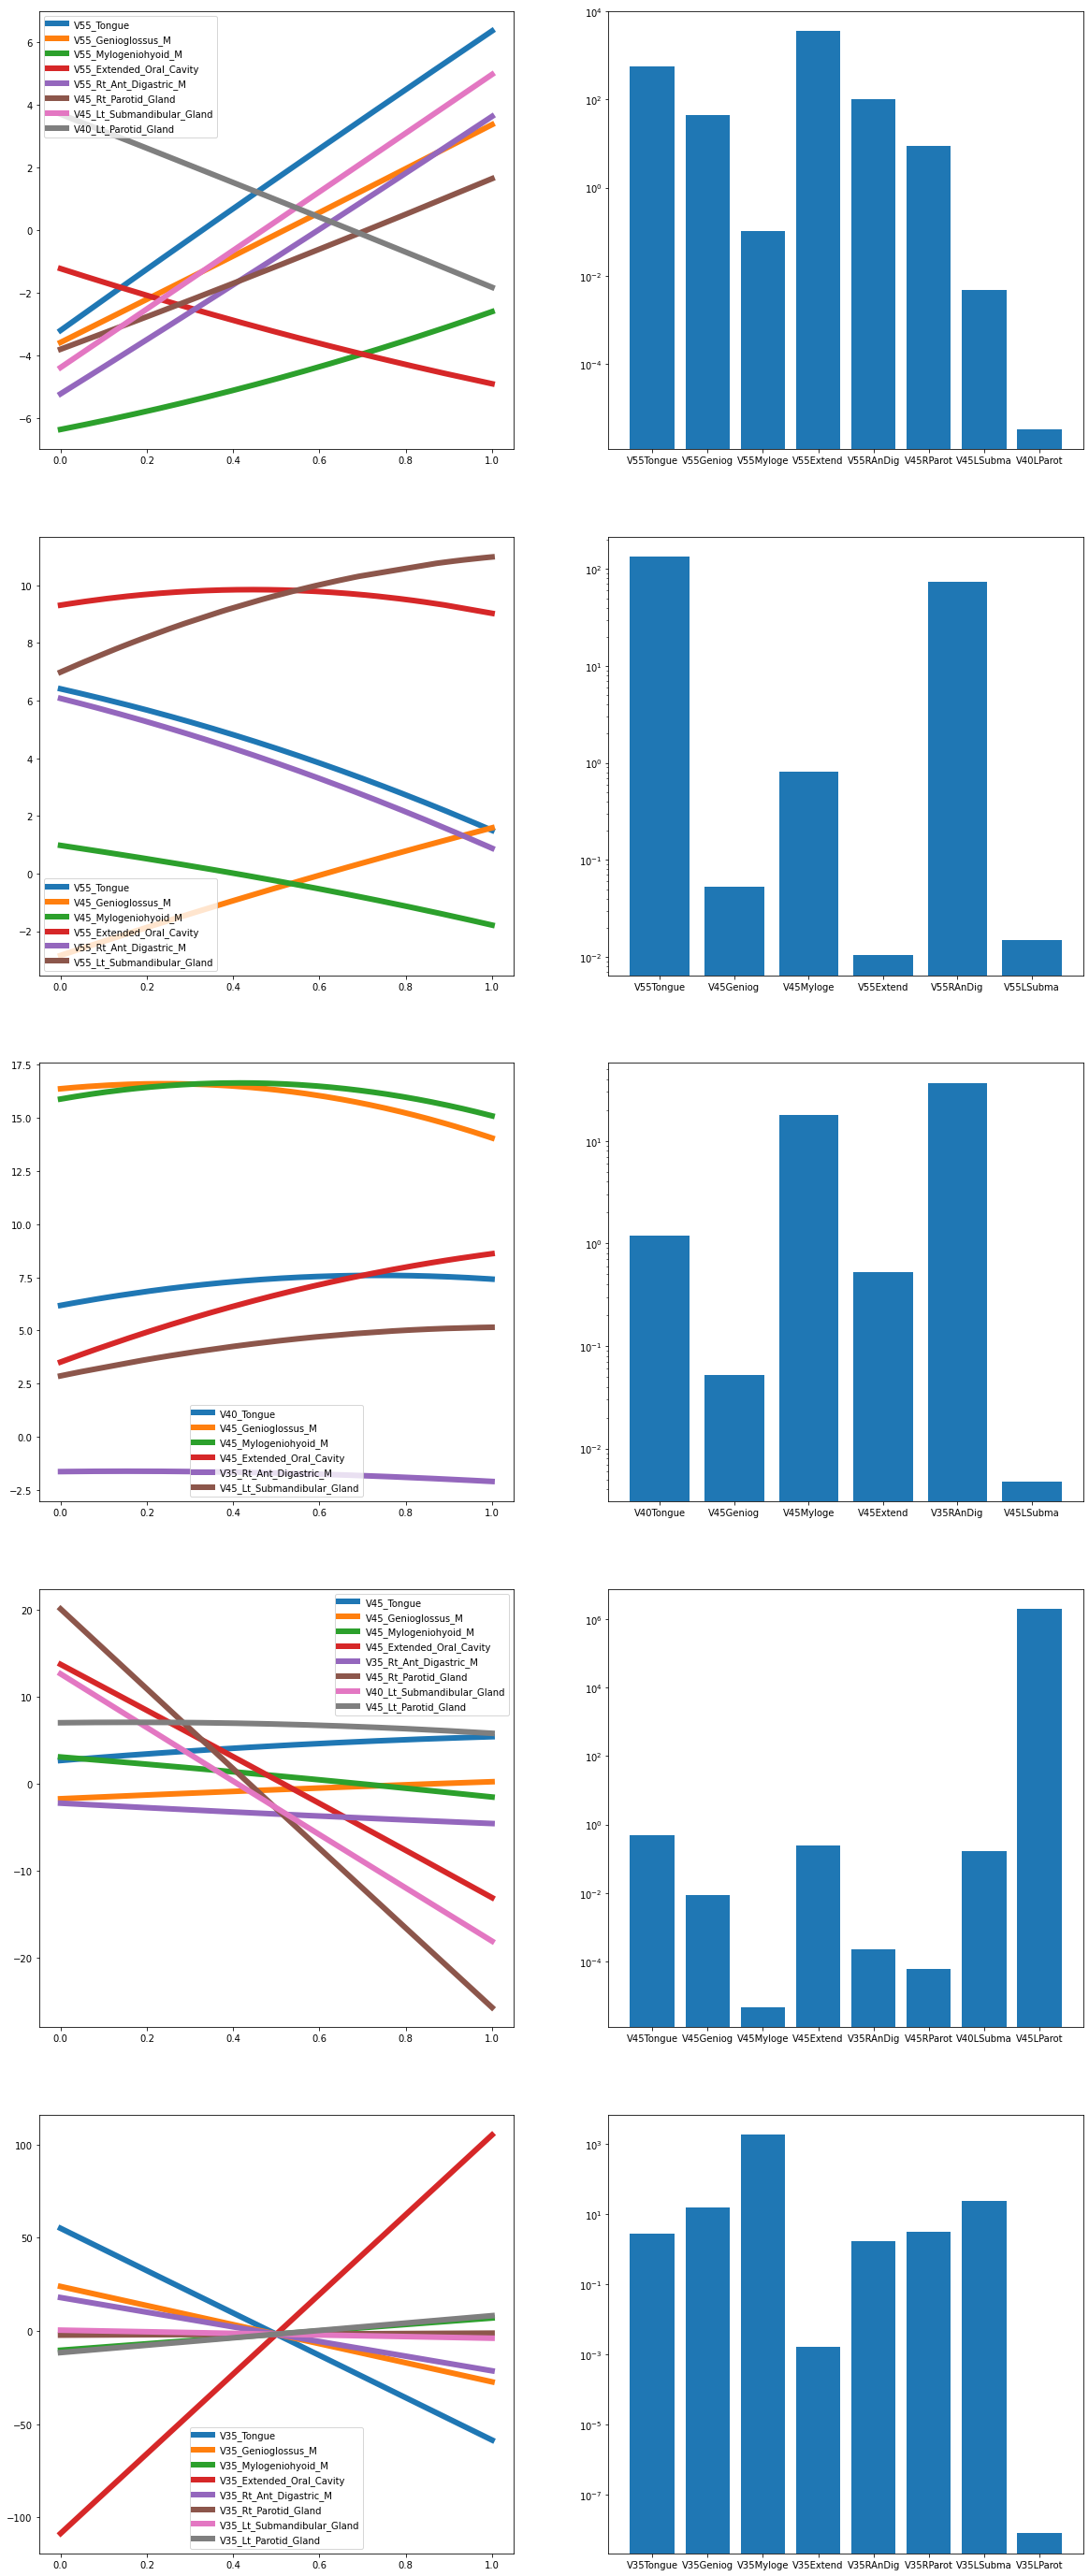

In [46]:
from pygam import LogisticGAM, LinearGAM
import pygam

def is_series_binary(series):
    #looks at a numeric pd series and tells you if the terms are 0 + 1 or not
    if(isinstance(series, pd.Series)):
        return series.isin([0,1]).all()
    else:
        return np.isin(series,[0,1]).all()

def select_gam_features(doses,outcome,organs=None,k=1,min_val = .05):
    #uses mutual info to figure out what features to keep for gam stuff
    #k values max (or whatever # has any mutual info) for each organ.
    #organs = None will just pick top k over all features
    x = doses.apply(lambda x: (x-x.mean())/x.std())
    x = doses.apply(lambda x: (x-x.min())/(x.max()-x.min()))
    def group_sranks(sval):
        if sval < 3:
            return 0
        if sval < 5:
            return 1
        if sval < 7:
            return 2
        return 3
    if not is_series_binary(outcome):
        y = outcome.apply(lambda x: x.apply(group_sranks),axis=0)
        rankfunc =mutual_info_regression
    else:
        y = outcome
        rankfunc = mutual_info_classif
    rankvals  = rankfunc(x.values,y.values.ravel(),random_state=1)
    min_val = min(min_val,np.max(rankvals))
    ranks = [(c,v) for c,v in zip(doses.columns,list(rankvals))]
    
    ranks = sorted(ranks, key=lambda x: -x[1])
    #top values with max k above min val
    #min val < 0 should just return everything for mutual info
    topk = lambda vals: [v for v in vals[:min(len(vals),k)] if v[1] >= min_val]
    to_keep = []
    if organs is not None:
        for o in organs:
            options = [i for i in ranks if o in i[0]]
            if len(options) < 1:
                continue
            to_keep.extend(topk(options))
    else:
        to_keep = topk(ranks)
    best_doses = doses[[i[0] for i in to_keep]]
    return best_doses

def make_gam_model(dose_df,
                   outcome_df,
                   organs=None,
                   threshold=5,
                   regularize=True,
                   gam_type='linear',
                   smoothing=.01,
                   n_splines =10,
                  ): 
    
    if threshold is not None:
        y = outcome_df >= threshold
    else:
        y = outcome_df/outcome_df.max()
        
    if(is_series_binary(y)):
        gamfunc = lambda terms: LogisticGAM(terms,max_iter=1000)
    else:
        gamfunc = lambda terms: LinearGAM(terms,max_iter=1000)
        
    if regularize:
        dose_df = dose_df.apply(lambda x: (x-x.mean() + .001)/(x.std() + .001),axis=0)
    x = dose_df.apply(lambda x: (x-x.min())/(x.max()-x.min()),axis=0)
    
    def get_term(term_idx):
        if(is_series_binary(x.values[:,term_idx])):
            return f(term_idx)
        elif(gam_type == 'linear'):
            return pygam.l(term_idx, smoothing)
        else:
            return pygam.s(term_idx, lam=smoothing,spline_order=n_splines-1,n_splines=n_splines)
    
    terms = get_term(0)
    for extra_term in np.arange(1,x.shape[1]):
        terms += get_term(extra_term)
    
    m = gamfunc(terms).fit(x,y)
    return m, x
       
def make_gam_curve(gam, x,x_unnormalized=None):
    curves = []
    curve_names = []
    quants = [.05,.25,.75,.95]
    print(x.shape,x_unnormalized.shape)
    if x_unnormalized is None:
        x_unnormalized = x
    for i,col in enumerate(x.columns):
        xvals = x[col].values
        
        xvals = np.unique(xvals)
        pdep_input = np.zeros((len(xvals),len(x.columns)))
        pdep_input[:,i] = xvals
        ypred = gam.partial_dependence(i, pdep_input,
                                       meshgrid=False,
                                       quantiles = quants,
                                      )
        xtrue = x_unnormalized[col].values
        curves.append([xvals,ypred[0]])
        curve_names.append(col)
    return curves,curve_names

def get_cluster_predictors(df):
    post_results = get_sample_cluster_metrics_input()
    
    df = add_post_clusters(df,post_results)
    df = add_confounder_dose_limits(df)
    confounders = post_results.get('lrtConfounders',['hpv','t3','t4','n_severe','Parotid_Gland_limit'])
    organs = post_results.get('organs',['IPC','MPC','SPC'])    
    organ_features = post_results.get('clusterFeatures',['V35','V40','V45','V55'])
    model_type= post_results.get('model_type','spline')
    models = []
    df_doses = extract_dose_vals(df,organs,organ_features)
    for cluster in df.post_cluster.unique():
        outcome = df['post_cluster'].apply(lambda x: x == cluster).astype(int)
        filtered_doses = select_gam_features(df_doses,outcome,organs=organs)
        gmodel, x = make_gam_model(
            filtered_doses,
            outcome,
            threshold=None,
            gam_type=model_type,
        )
        pdep, pdep_names = make_gam_curve(gmodel,x,filtered_doses)
        if model_type != 'linear':
            lmodel, _ = make_gam_model(
                filtered_doses,
                outcome,
                threshold=None,
                gam_type='linear',
            )
            odds = np.exp(lmodel.coef_)
        else:
            odds = np.exp(gmodel.coef_)
        entry = {
            'model':gmodel,
            'pdep': pdep,
            'pdep_names':pdep_names,
            'model_type':model_type,
            'odds': odds,
            'cluster': cluster,
            'features': list(filtered_doses.columns),
        }
        models.append(entry)
    return models


def plot_gam_pdep(gtest_entry,ax=None):
    if ax is None:
        fig,ax = plt.subplots(1,1)
    for [[x,y],name] in zip(gtest_entry['pdep'],gtest_entry['pdep_names']):
        line, = ax.plot(x,y,linewidth=6)
        line.set_label(name)
    return ax

def plot_gam_odds(gentry,ax=None,log=True):
    import matplotlib.pyplot as plt
    if ax is None:
        fig,ax = plt.subplots(1,1)
    fnames = [f.replace('t_','').replace('_','')[:9] for f in gentry['features']]
    odds = gentry['odds'][1:]
    x = [i for i,f in enumerate(odds)]
    ax.bar(x,odds,tick_label=fnames,log=log)
    
def plot_cluster_gam_results(gamstuff):
    import matplotlib.pyplot as plt
    nitems = len(gamstuff)
    fig,axes = plt.subplots(nitems,2,figsize=(20,10*nitems))
    for arow,gitem in zip(axes,gamstuff):
        ax = arow[0]
        plot_gam_pdep(gitem,ax)
        plot_gam_odds(gitem,arow[1])
        ax.legend()
        
# temp = get_cluster_predictors(data)
plot_cluster_gam_results(temp)
temp[0]['odds']

In [ ]:
temp = [t for t in test if len(t['features']) > 1]
temprule = temp[0]['rule']

In [ ]:


def extract_confounders(df,confounders):
    new_vals = {}
    for col in confounders:
        vals =df[col]
        unique_vals = vals.unique()
        if(len(unique_vals)) <= 2:
            new_vals[col] = (vals == vals.max()).values
        elif len(unique_vals) < 10:
            for uval in unique_vals:
                new_vals[col+'_'+str(uval)] = (vals == uval).values
        else:
            try:
                new_vals[col] = pd.to_numeric(vals,errors='coerce').fillna(0).values
            except Exception as e:
                print('error with column',)
    return pd.DataFrame(new_vals,index=df.index)
    
    
def get_gam_inference_data(df,
                           confounders,
                           organs,
                           symptoms,
                           features, 
                           dates, 
                           cluster=None):
    if cluster is not None:
        df = df[df.post_cluster.astype(int) == int(c)]
    df_doses = extract_dose_vals(df,organs,features)
    df_confounders = extract_confounders(df,confounders)
    outcome = get_outcomes(df,symptoms,dates)
    return [df_doses,outcome,df_confounders]
       


def get_stuff(df):
    post_results = get_sample_cluster_metrics_input()
    
    df = add_post_clusters(df,post_results)
    df = add_confounder_dose_limits(df)
    confounders = post_results.get('lrtConfounders',['hpv','t3','t4','n_severe','Parotid_Gland_limit'])
    organs = post_results.get('organs',['IPC','MPC','SPC'])
    symptoms = post_results.get('symptoms',['drymouth'])
    organ_features = post_results.get('clusterFeatures',['V35','V40','V45','V55'])
    s_dates = post_results.get('symptom_dates',[13,33])
#     model_type= post_results.get('model_type','spline')
    threshold = post_results.get('threshold',None)
    
    models = []
    dose_df, outcome_df, confounder_df = get_gam_inference_data(df,
                                                              confounders,organs,
                                                              symptoms,
                                                              organ_features,
                                                              s_dates,
                                                             )
    for cluster in df.post_cluster.unique() + [-1]:
        if cluster is not None and cluster > -1:
            cluster_index = df[df.post_cluster == cluster].index
        else:
            cluster_index = df.index
        target = outcome_df[symptoms].loc[cluster_index]
        filtered_doses = select_gam_features(dose_df.loc[cluster_index],
                                             target,
                                             organs=organs,
                                            )
        for model_type in ['spline','linear']:
            gmodel, x = make_gam_model(
                filtered_doses,
                target,
                threshold=threshold,
                gam_type=model_type,
            )
            pdep, pdep_names = make_gam_curve(gmodel,x,filtered_doses)
            entry = {
                'symptom': symptoms[0],
                'model':gmodel,
                'threshold': threshold,
                'cluster': cluster,
                'pdep': pdep,
                'pdep_names':pdep_names,
                'model_type':model_type,
            }
            models.append(entry)
    for entry in models:
        pass
    return models



def plot_gam_results(gamstuff):
    nitems = len(gamstuff)
    n_rows = nitems//2
    if n_rows < nitems/2:
        n_rows += 1
    fig,axes = plt.subplots(n_rows,2,figsize=(20,10*n_rows))
    col = 0
    row = 0
    for gitem in gamstuff:
        ax = axes[row,col]
        plot_gam_pdep(gitem,ax)
        col += 1
        if col > 1:
            row += 1
            col = 0
        ax.legend()
temp = get_stuff(data)
plot_gam_results(temp)

In [ ]:

def get_tree_stuff(df):
    post_results = get_sample_cluster_metrics_input()
    
    df = add_post_clusters(df,post_results)
    df = add_confounder_dose_limits(df)
    confounders = post_results.get('lrtConfounders',['hpv','t3','t4','n_severe','Parotid_Gland_limit'])
    organs = post_results.get('organs',['IPC','MPC','SPC'])
    symptoms = post_results.get('symptoms',['drymouth'])
    organ_features = post_results.get('clusterFeatures',['V35','V40','V45','V55'])
    s_dates = post_results.get('symptom_dates',[13,33])
    threshold = post_results.get('threshold',5)
    cluster = post_results.get('cluster',None)
    
    dose_df, outcome_df, confounder_df = get_gam_inference_data(df,
                                                              confounders,organs,
                                                              symptoms,
                                                              organ_features,
                                                              s_dates,
                                                            cluster=cluster,
                                                             )
    y = (outcome_df>=threshold)
    print(dose_df.shape,y.shape)
    
    forest = RandomForestClassifier(n_estimators=1000,
                                    min_samples_leaf=int(dose_df.shape[0]/4),
                                    max_depth = 2)
    forest.fit(dose_df,y.values.ravel())
    rules = {}
    for estimator in forest.estimators_:
        t = estimator.tree_
        for (feature, thresh) in zip(t.feature,t.threshold):
            if feature < 0:
                continue
            fname = dose_df.columns[feature] 
            curr_ts = rules.get(fname,{})
            tcount = curr_ts.get(thresh,0)
            curr_ts[thresh] = tcount + 1
            rules[fname] = curr_ts
    rlist = []
    for feature, tentry in rules.items():
        for thresh, count in tentry.items():
            upper_split_idx = dose_df[(dose_df[feature] > thresh)].index
            lower_split_idx = dose_df[(dose_df[feature] <= thresh)].index
            rentry = {
                'feature': feature,
                'threshold': thresh,
                'rulecount': count,
                'upper_split_count': len(upper_split_idx),
                'lower_split_count': len(lower_split_idx),
                'upper_split_tp': y.loc[upper_split_idx].sum().values[0],
                'lower_split_tp': y.loc[lower_split_idx].sum().values[0],
                'upper_split_mean': y.loc[upper_split_idx].mean().values[0],
                'lower_split_mean': y.loc[lower_split_idx].mean().values[0],
            }
            rentry['odds_ratio'] = (rentry['upper_split_mean'] + .01)/(rentry['lower_split_mean'] + .01)
            rlist.append(rentry)
    rlist = sorted(rlist, key = lambda x: -x['odds_ratio'])
    return rlist
get_tree_stuff(data)

In [ ]:
extract_dose_vals(data,['IPC',"MPC"],['V35','V45']).min().min()

In [ ]:
# def select_single_organ_cluster_effects(df,
#                                         symptoms=None,
#                                         base_organs=None,
#                                         covars=None,
#                                         n_clusters=4,
#                                         clustertype=None,
#                                         threshold=None,
#                                         drop_base_cluster=True,
#                                         features=None,
#                                         organ_list=None):
#     if base_organs is None:
#         base_organs = []
#     if organ_list is None:
#         #imma just skip stuff that's like probably not relevant for this usage
#         exclude = set(['Brainstem',"Spinal_Cord",
#                    'Lt_Brachial_Plexus','Rt_Brachial_Plexus',
#                    'Lower_Lip',"Upper_Lip",
#                    'Hyoid_bone','Mandible',
#                    'Cricoid_cartilage',
#                     'Thyroid_cartilage',
#                   ])
#         organ_list = [o for o in Const.organ_list if o not in exclude]
#     if symptoms is None:
#         symptoms=Const.symptoms[:]
#     if isinstance(symptoms,str):
#         symptoms=[symptoms]
#     df = add_late_symptoms(df,symptoms)
#     df = add_confounder_dose_limits(df)
#     olists = [base_organs] if len(base_organs) > 0 else []
#     for o in organ_list:
#         if o in base_organs:
#             continue
#         if 'Rt_' in o:
#             continue
#         new_list = [o]
#         if len(base_organs) > 0:
#             new_list = new_list + base_organs
#         if 'Lt_' in o:
#             new_list.append(o.replace('Lt_','Rt_'))
#         if len(new_list) > len(base_organs):
#             olists.append(new_list)
#     if covars is None:
#         covars = [
#             'Parotid_Gland_limit',
#           'IPC_limit','MPC_limit','SPC_limit',
#           't4','n3','hpv','total_dose',
#           "BOT","Tonsil",
#          ]
#     df = df.copy()
#     df['total_dose'] = df.mean_dose.apply(lambda x: np.sum(x))
#     results = []
#     base_pval = 1
#     completed_clusters = set([])
    
#     clusterer = None
#     if clustertype is not None:
#         clusterer = keyword_clusterer(clustertype,n_clusters)
#     for olist in olists:
#         prefix = '_'.join(olist)+'_'
#         df  = add_sd_dose_clusters(df,
#                                      features = features,
#                                      organ_subset=olist,
#                                      prefix=prefix,
#                                     clusterer=clusterer,
#                                      n_clusters=n_clusters,
#             )
#         clustname = prefix+'dose_clusters'
#         xvals = []
#         for cval in df[clustname].unique():
#             if cval == 0 and drop_base_cluster:
#                 continue
#             df['x'+str(cval)] = (df[clustname] == cval).astype(int)
#             xvals.append('x'+str(cval))
            
#         for symptom in symptoms:
#             outcome = symptom + '_late'
#             if threshold is None:
#                 df['y'] = df[outcome]
#             else:
#                 df['y'] = (df[outcome] >= threshold)
#             res = multi_var_tests(df,xvals,'y',covars,boolean=(threshold is not None))
#             entry = {
#                 'outcome':outcome,
#                 'base_organs':base_organs,
#                 'added_organs':sorted(set(olist)-set(base_organs)),
#                 'threshold':threshold,
#                 'clustertype':clustertype,
#             }
#             if ''.join(olist) == ''.join(base_organs):
#                 base_pval = res['lrt_pval']
#             entry['pval_change'] = base_pval - res['lrt_pval']
#             for k,v in res.items():
#                 entry[k] = v
#             results.append(entry)
#     #sort by effect size of highest-dose cluster
#     results= sorted(results,key=lambda x: -x['ttest_tval_x'+str(n_clusters-1)])
#     return results